# ❶ Imports & Settings

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import sqlite3

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Ethiopian season mapping function
def map_ethiopian_seasons(month):
    """Maps month number to Ethiopian season name."""
    if month in [10, 11, 12, 1, 2]:
        return 'Dry Season'
    elif month in [3, 4, 5]:
        return 'Belg Rainy Season'
    else:  # months 6–9
        return 'Kiremt Rainy Season'

# ❷ Load & Index Data

In [29]:
# — adjust path to your cleaned CSV —
path = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv"


df = pd.read_csv(
    path,
    parse_dates=[['Date local (yyyy/MM/dd)', 'Time local (hh:mm:ss)']],
    infer_datetime_format=True
)
df.rename(columns={'Date local (yyyy/MM/dd)_Time local (hh:mm:ss)': 'datetime_local'}, inplace=True)
df['datetime_local'] = pd.to_datetime(df['datetime_local'])
df.set_index('datetime_local', inplace=True)
df.index = df.index.floor('min')  # Ensure clean 1-min resolution
df.sort_index(inplace=True)

df.head(), df.index.min(), df.index.max()

/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_22752/1994281256.py:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_22752/1994281256.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


(                    Serial number            Time (UTC)  Datum ID  Session ID  \
 datetime_local                                                                  
 2022-04-12 09:46:00    MA350-0238  2022-04-12T09:46:01Z     26133          12   
 2022-04-12 09:47:00    MA350-0238  2022-04-12T09:47:01Z     26134          12   
 2022-04-12 09:48:00    MA350-0238  2022-04-12T09:48:01Z     26135          12   
 2022-04-12 09:49:00    MA350-0238  2022-04-12T09:49:01Z     26136          12   
 2022-04-12 09:50:00    MA350-0238  2022-04-12T09:50:01Z     26137          12   
 
                      Data format version  Firmware version  App version  \
 datetime_local                                                            
 2022-04-12 09:46:00                    1               1.1          1.4   
 2022-04-12 09:47:00                    1               1.1          1.4   
 2022-04-12 09:48:00                    1               1.1          1.4   
 2022-04-12 09:49:00                    1   

# ❸ Build Expected 1-Minute Timeline

In [30]:
start, end = df.index.min(), df.index.max()
expected_idx = pd.date_range(start, end, freq='min')
print(f"Expected points: {len(expected_idx)}")

Expected points: 1239796


# ❹ Identify Missing Timestamps

In [31]:
actual_idx = df.index.unique().sort_values()
missing_idx = expected_idx.difference(actual_idx)
print(f"Actual   points: {len(actual_idx)}")
print(f"Missing  points: {len(missing_idx)} "
      f"({len(missing_idx)/len(expected_idx)*100:.2f}% of timeline)")

missing_idx[:10]

Actual   points: 1095086
Missing  points: 144710 (11.67% of timeline)


DatetimeIndex(['2022-04-13 07:33:00', '2022-04-13 07:34:00',
               '2022-04-14 07:09:00', '2022-04-14 07:10:00',
               '2022-04-14 07:11:00', '2022-04-14 07:12:00',
               '2022-04-14 07:13:00', '2022-04-14 07:14:00',
               '2022-04-14 07:15:00', '2022-04-14 07:16:00'],
              dtype='datetime64[ns]', freq=None)

# ❺ Missing-Data Summaries

## 5.1 Daily Missing Minutes

In [32]:
miss_per_day = pd.Series(1, index=missing_idx).groupby(missing_idx.date).count()
miss_per_hour = pd.Series(1, index=missing_idx).groupby(missing_idx.hour).count()


## 5.2 Hourly Missing Pattern

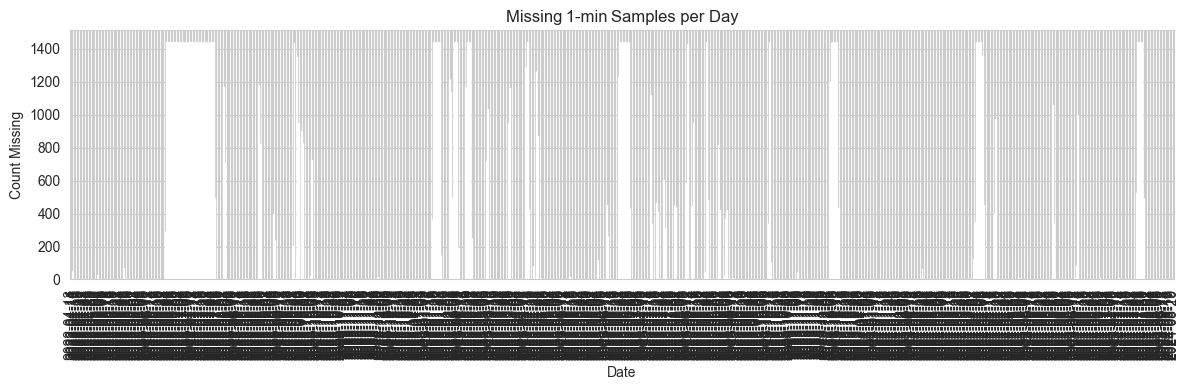

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))
miss_per_day.plot(kind='bar', ax=ax)
ax.set_title("Missing 1-min Samples per Day")
ax.set_xlabel("Date")
ax.set_ylabel("Count Missing")
plt.tight_layout()
plt.show()

## 5.3 Monthly × Yearly Heatmap (Seasonality)

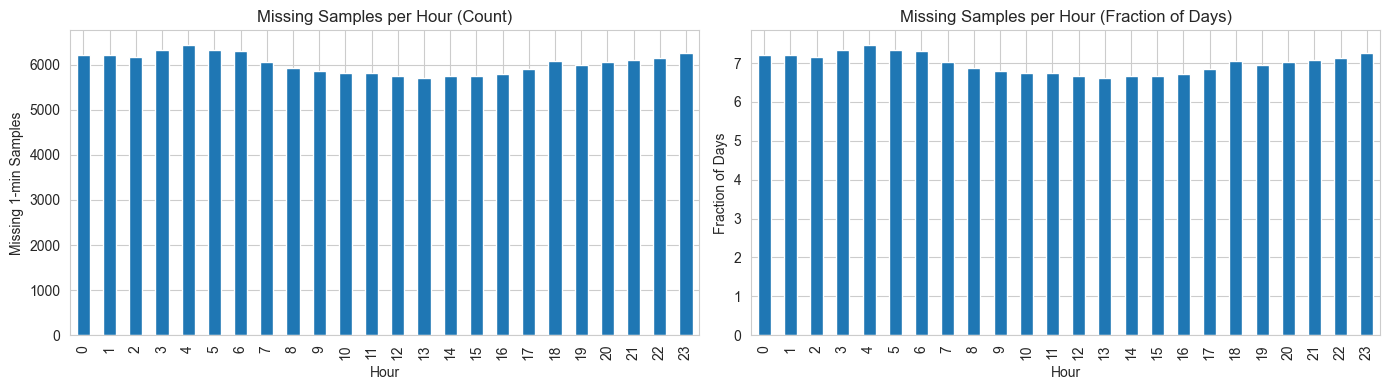

In [34]:
n_days = (end.date() - start.date()).days + 1
miss_frac_hour = miss_per_hour / n_days

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
miss_per_hour.plot.bar(ax=axes[0])
axes[0].set_title("Missing Samples per Hour (Count)")
axes[0].set_xlabel("Hour")
axes[0].set_ylabel("Missing 1-min Samples")

miss_frac_hour.plot.bar(ax=axes[1])
axes[1].set_title("Missing Samples per Hour (Fraction of Days)")
axes[1].set_xlabel("Hour")
axes[1].set_ylabel("Fraction of Days")
plt.tight_layout()
plt.show()

# ❻ Column-Level Missingness (Optional)

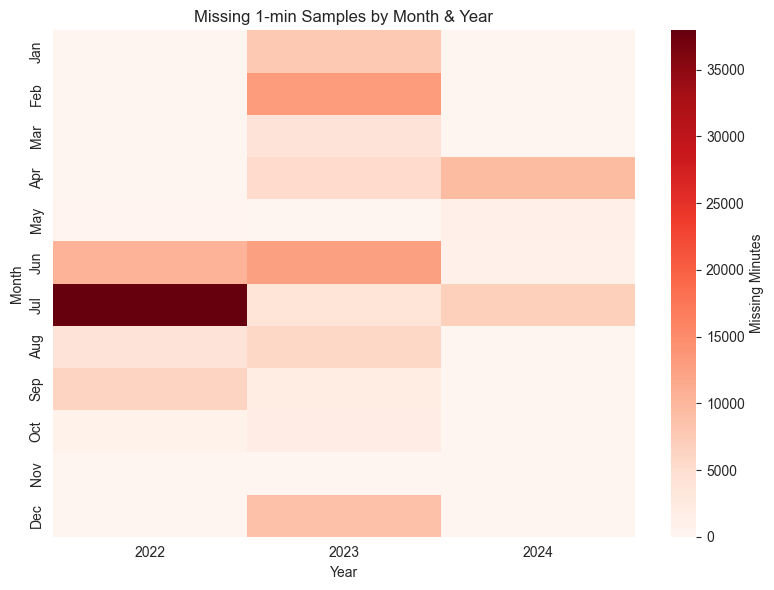

In [35]:
miss_df = pd.DataFrame(index=missing_idx)
miss_df['year'] = miss_df.index.year
miss_df['month'] = miss_df.index.month

pivot_my = miss_df.groupby(['month', 'year']).size().unstack(fill_value=0)

plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot_my,
    cmap='Reds',
    cbar_kws={'label': 'Missing Minutes'},
    yticklabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
)
plt.title("Missing 1-min Samples by Month & Year")
plt.xlabel("Year")
plt.ylabel("Month")
plt.tight_layout()
plt.show()

# ❼ Diurnal Missingness Analysis

In [36]:
bc_cols = [c for c in df.columns if c.endswith('BCc')]
col_missing = df[bc_cols].isna().sum().sort_values(ascending=False)
col_missing_pct = (col_missing / len(df) * 100).round(2)

pd.DataFrame({
    'count_missing': col_missing,
    'pct_missing': col_missing_pct
})


,count_missing,pct_missing
UV BCc,332,0.03
Blue BCc,332,0.03
Green BCc,332,0.03
Red BCc,332,0.03
IR BCc,332,0.03


# ❾ Yearly & Seasonal Diurnal Missingness

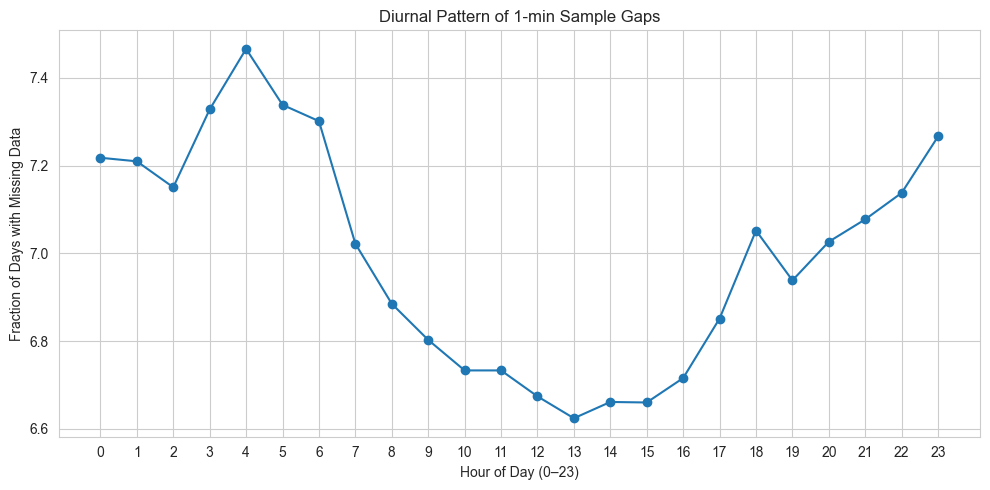

,frac_days_missing
0,7.218097
1,7.209977
2,7.150812
3,7.328306
4,7.466357
5,7.338747
6,7.301624
7,7.022042
8,6.885151
9,6.802784


In [37]:
miss_count_by_hour = pd.Series(1, index=missing_idx).groupby(missing_idx.hour).count()
miss_frac_by_hour = miss_count_by_hour / n_days

plt.figure(figsize=(10, 5))
plt.plot(miss_frac_by_hour.index, miss_frac_by_hour.values, marker='o')
plt.xticks(range(0, 24))
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Fraction of Days with Missing Data')
plt.title('Diurnal Pattern of 1-min Sample Gaps')
plt.grid(True)
plt.tight_layout()
plt.show()

miss_frac_by_hour.to_frame('frac_days_missing')

# 🔟 Weekly Diurnal Patterns by Year & Ethiopian Season


Analyzing Ethiopian seasonal missing patterns...


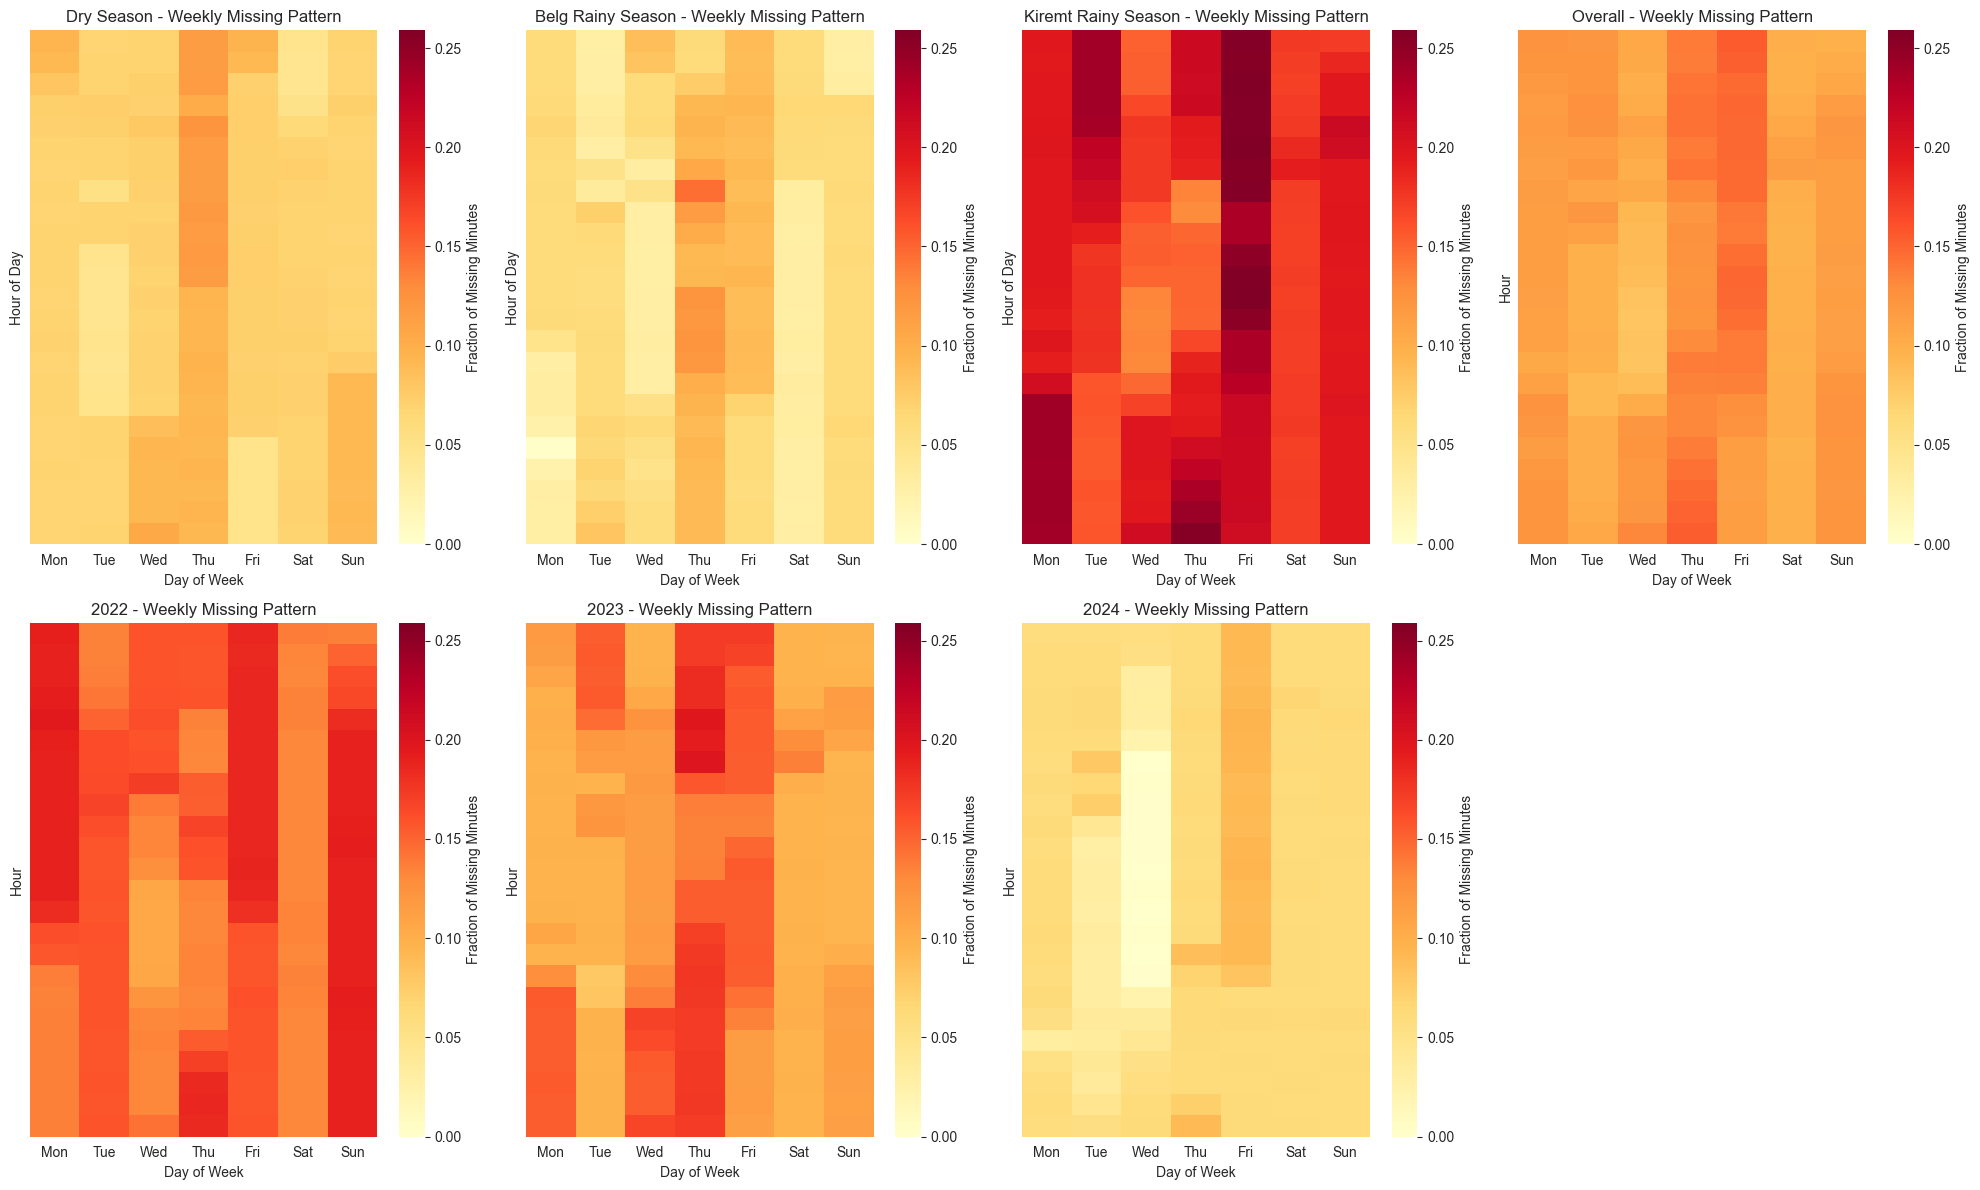


=== Fraction of Missing Minutes by Season ===

Dry Season:



DayOfWeek,0,1,2,3,4,5,6
Hour,,,,,,,
0,0.094,0.068,0.070,0.116,0.095,0.047,0.070
1,0.092,0.070,0.070,0.116,0.091,0.047,0.068
2,0.081,0.069,0.072,0.117,0.071,0.047,0.068
3,0.072,0.074,0.072,0.104,0.074,0.050,0.072
4,0.071,0.073,0.079,0.123,0.074,0.063,0.069
5,0.069,0.070,0.072,0.117,0.072,0.071,0.068
6,0.068,0.070,0.072,0.116,0.072,0.073,0.069
7,0.070,0.053,0.071,0.116,0.072,0.071,0.069
8,0.068,0.069,0.070,0.119,0.071,0.070,0.069



Belg Rainy Season:



DayOfWeek,0,1,2,3,4,5,6
Hour,,,,,,,
0,0.061,0.030,0.087,0.063,0.089,0.062,0.031
1,0.061,0.031,0.083,0.061,0.088,0.061,0.030
2,0.061,0.031,0.061,0.075,0.089,0.063,0.032
3,0.064,0.035,0.060,0.093,0.093,0.065,0.066
4,0.068,0.037,0.063,0.096,0.091,0.063,0.063
5,0.064,0.031,0.050,0.092,0.089,0.063,0.062
6,0.061,0.050,0.031,0.106,0.091,0.061,0.062
7,0.063,0.036,0.050,0.145,0.088,0.033,0.064
8,0.062,0.072,0.030,0.117,0.092,0.032,0.062



Kiremt Rainy Season:



DayOfWeek,0,1,2,3,4,5,6
Hour,,,,,,,
0,0.196,0.240,0.152,0.213,0.256,0.174,0.174
1,0.196,0.240,0.153,0.213,0.255,0.172,0.187
2,0.197,0.240,0.153,0.213,0.257,0.170,0.196
3,0.197,0.241,0.165,0.214,0.257,0.174,0.196
4,0.198,0.238,0.177,0.193,0.257,0.174,0.214
5,0.199,0.224,0.175,0.193,0.259,0.185,0.212
6,0.196,0.218,0.175,0.190,0.255,0.193,0.197
7,0.197,0.212,0.175,0.134,0.256,0.173,0.196
8,0.196,0.207,0.160,0.129,0.235,0.172,0.198



=== Fraction of Missing Minutes Overall ===


DayOfWeek,0,1,2,3,4,5,6
Hour,,,,,,,
0,0.123,0.122,0.105,0.139,0.155,0.100,0.098
1,0.122,0.123,0.104,0.138,0.153,0.098,0.102
2,0.119,0.123,0.099,0.142,0.147,0.098,0.107
3,0.117,0.126,0.103,0.143,0.149,0.101,0.117
4,0.118,0.125,0.111,0.143,0.148,0.106,0.122
5,0.116,0.117,0.104,0.139,0.148,0.112,0.120
6,0.114,0.120,0.099,0.142,0.147,0.115,0.115
7,0.115,0.108,0.104,0.131,0.147,0.099,0.115
8,0.114,0.122,0.093,0.122,0.140,0.099,0.115



=== Fraction of Missing Minutes by Year ===

2022:



DayOfWeek,0,1,2,3,4,5,6
Hour,,,,,,,
0,0.191,0.135,0.160,0.160,0.185,0.138,0.136
1,0.189,0.135,0.159,0.158,0.184,0.133,0.151
2,0.189,0.137,0.160,0.158,0.186,0.132,0.162
3,0.192,0.141,0.160,0.160,0.186,0.135,0.166
4,0.195,0.151,0.162,0.135,0.185,0.135,0.182
5,0.191,0.163,0.160,0.133,0.185,0.132,0.190
6,0.190,0.163,0.161,0.132,0.185,0.132,0.190
7,0.190,0.164,0.172,0.154,0.186,0.132,0.190
8,0.190,0.168,0.139,0.154,0.185,0.132,0.189



2023:



DayOfWeek,0,1,2,3,4,5,6
Hour,,,,,,,
0,0.117,0.154,0.096,0.174,0.173,0.097,0.096
1,0.116,0.156,0.096,0.173,0.169,0.097,0.094
2,0.107,0.154,0.097,0.183,0.155,0.097,0.096
3,0.099,0.156,0.106,0.182,0.158,0.099,0.116
4,0.099,0.146,0.124,0.197,0.155,0.111,0.114
5,0.099,0.121,0.116,0.192,0.155,0.129,0.107
6,0.096,0.117,0.117,0.200,0.154,0.136,0.095
7,0.097,0.096,0.119,0.158,0.154,0.100,0.095
8,0.097,0.120,0.116,0.137,0.137,0.097,0.096



2024:



DayOfWeek,0,1,2,3,4,5,6
Hour,,,,,,,
0,0.059,0.059,0.057,0.061,0.092,0.061,0.061
1,0.060,0.060,0.055,0.062,0.092,0.061,0.061
2,0.060,0.060,0.032,0.061,0.091,0.061,0.061
3,0.062,0.064,0.033,0.063,0.093,0.066,0.063
4,0.062,0.064,0.032,0.066,0.095,0.063,0.065
5,0.061,0.061,0.023,0.063,0.094,0.063,0.063
6,0.059,0.078,0.001,0.062,0.094,0.064,0.063
7,0.062,0.065,0.003,0.063,0.091,0.061,0.063
8,0.059,0.074,0.002,0.064,0.092,0.063,0.064


In [38]:
def analyze_missingness_by_season_week(df):
    """Analyze weekly diurnal missing patterns by Ethiopian season and return pivot tables."""

    print("\nAnalyzing Ethiopian seasonal missing patterns...")

    # Define expected full-minute timeline
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq='min')
    actual_idx = df.index.unique().sort_values()
    missing_idx = full_idx.difference(actual_idx)

    # Create DataFrame to mark missing data
    miss_df = pd.DataFrame(index=full_idx)
    miss_df['is_missing'] = 0
    miss_df.loc[missing_idx, 'is_missing'] = 1

    # Add time features
    miss_df['Hour'] = miss_df.index.hour
    miss_df['DayOfWeek'] = miss_df.index.dayofweek
    miss_df['Month'] = miss_df.index.month
    miss_df['Year'] = miss_df.index.year
    miss_df['Ethiopian_Season'] = miss_df['Month'].map(map_ethiopian_seasons)

    # Setup
    seasons = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    years = sorted(miss_df['Year'].unique())

    # Create pivot tables
    season_pivots = {
        season: miss_df[miss_df['Ethiopian_Season'] == season]
                .pivot_table(index='Hour', columns='DayOfWeek', values='is_missing', aggfunc='mean')
        for season in seasons
    }

    year_pivots = {
        year: miss_df[miss_df['Year'] == year]
               .pivot_table(index='Hour', columns='DayOfWeek', values='is_missing', aggfunc='mean')
        for year in years
    }

    overall_pivot = miss_df.pivot_table(index='Hour', columns='DayOfWeek', values='is_missing', aggfunc='mean')

    # Global max for color scaling
    all_pivots = list(season_pivots.values()) + list(year_pivots.values()) + [overall_pivot]
    vmax = max(p.max().max() for p in all_pivots)

    # Plot heatmaps
    fig, axes = plt.subplots(2, 4, figsize=(20, 12), sharey=True)
    axes = axes.flatten()

    for i, season in enumerate(seasons):
        sns.heatmap(
            season_pivots[season], ax=axes[i],
            cmap='YlOrRd', vmin=0, vmax=vmax,
            xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
            yticklabels=[f'{h:02d}:00' for h in range(24)],
            cbar_kws={'label': 'Fraction of Missing Minutes'}
        )
        axes[i].set_title(f"{season} - Weekly Missing Pattern")
        axes[i].set_xlabel("Day of Week")
        axes[i].set_ylabel("Hour of Day")

    sns.heatmap(
        overall_pivot, ax=axes[3],
        cmap='YlOrRd', vmin=0, vmax=vmax,
        xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
        yticklabels=False,
        cbar_kws={'label': 'Fraction of Missing Minutes'}
    )
    axes[3].set_title("Overall - Weekly Missing Pattern")
    axes[3].set_xlabel("Day of Week")

    for j, year in enumerate(years):
        if 4 + j >= len(axes):
            break
        sns.heatmap(
            year_pivots[year], ax=axes[4 + j],
            cmap='YlOrRd', vmin=0, vmax=vmax,
            xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
            yticklabels=False,
            cbar_kws={'label': 'Fraction of Missing Minutes'}
        )
        axes[4 + j].set_title(f"{year} - Weekly Missing Pattern")
        axes[4 + j].set_xlabel("Day of Week")

    for k in range(4 + len(years), len(axes)):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n=== Fraction of Missing Minutes by Season ===")
    for season in seasons:
        print(f"\n{season}:\n")
        display(season_pivots[season].round(3))

    print("\n=== Fraction of Missing Minutes Overall ===")
    display(overall_pivot.round(3))

    print("\n=== Fraction of Missing Minutes by Year ===")
    for year in years:
        print(f"\n{year}:\n")
        display(year_pivots[year].round(3))

    return {
        'seasonal_pivots': season_pivots,
        'yearly_pivots': year_pivots,
        'overall': overall_pivot
    }

# Run the analysis
results = analyze_missingness_by_season_week(df)

In [39]:
def summarize_missingness(df):
    """Print summary stats for missingness, including full and partial day gaps."""

    print("📊 Summary of Missingness and Data Coverage\n")

    # Time range
    start, end = df.index.min(), df.index.max()
    duration = end - start
    print(f"• Time range: {start} → {end}  ({duration.days} days)")
    print(f"• Total rows in dataframe: {len(df):,}")

    # Expected full timeline
    full_idx = pd.date_range(start, end, freq='min')
    expected_days = pd.date_range(start.date(), end.date(), freq='D')
    expected_minutes = len(full_idx)
    actual_minutes = df.index.floor('min').nunique()
    missing_minutes = expected_minutes - actual_minutes
    missing_pct = (missing_minutes / expected_minutes) * 100

    print(f"• Expected total minutes: {expected_minutes:,}")
    print(f"• Actual recorded minutes: {actual_minutes:,}")
    print(f"• Missing minutes: {missing_minutes:,} ({missing_pct:.2f}%)")

    # Identify missing timestamps
    actual_idx = df.index.unique().sort_values()
    missing_idx = full_idx.difference(actual_idx)

    # Daily missing counts
    missing_per_day = pd.Series(1, index=missing_idx).groupby(missing_idx.date).count()
    full_day_missing = missing_per_day[missing_per_day == 1440]
    partial_missing = missing_per_day[missing_per_day < 1440]

    print(f"• Days with full 100% missing data: {len(full_day_missing)}")
    if not full_day_missing.empty:
        print("  ⟶ Dates with full missing:")
        for d in full_day_missing.index[:5]:  # preview
            print(f"     - {d}")
        if len(full_day_missing) > 5:
            print("     ...")

    print(f"• Days with partial missing minutes: {len(partial_missing)}")

    # Optional: stats for partially missing days
    if not partial_missing.empty:
        print("\n📈 Stats for partially missing days:")
        print(f"• Avg missing minutes/day: {partial_missing.mean():.1f}")
        print(f"• Median missing minutes/day: {partial_missing.median():.1f}")
        print(f"• Max missing in one day: {partial_missing.max()}")
        worst_day = partial_missing.idxmax()
        print(f"  ⟶ Worst partial missing day: {worst_day} ({partial_missing.max()} min missing)")

    print("\n✅ Summary complete.\n")

# Run the summary
summarize_missingness(df)


📊 Summary of Missingness and Data Coverage

• Time range: 2022-04-12 09:46:00 → 2024-08-20 09:01:00  (860 days)
• Total rows in dataframe: 1,095,086
• Expected total minutes: 1,239,796
• Actual recorded minutes: 1,095,086
• Missing minutes: 144,710 (11.67%)
• Days with full 100% missing data: 68
  ⟶ Dates with full missing:
     - 2022-06-24
     - 2022-06-25
     - 2022-06-26
     - 2022-06-27
     - 2022-06-28
     ...
• Days with partial missing minutes: 684

📈 Stats for partially missing days:
• Avg missing minutes/day: 68.4
• Median missing minutes/day: 2.0
• Max missing in one day: 1432
  ⟶ Worst partial missing day: 2023-08-11 (1432 min missing)

✅ Summary complete.




🔍 Plotting Missingness (Excluding Fully Missing Days)...


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_22752/454869200.py:17: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  partial_missing_idx = missing_idx[~missing_idx.normalize().isin(full_days_missing)]


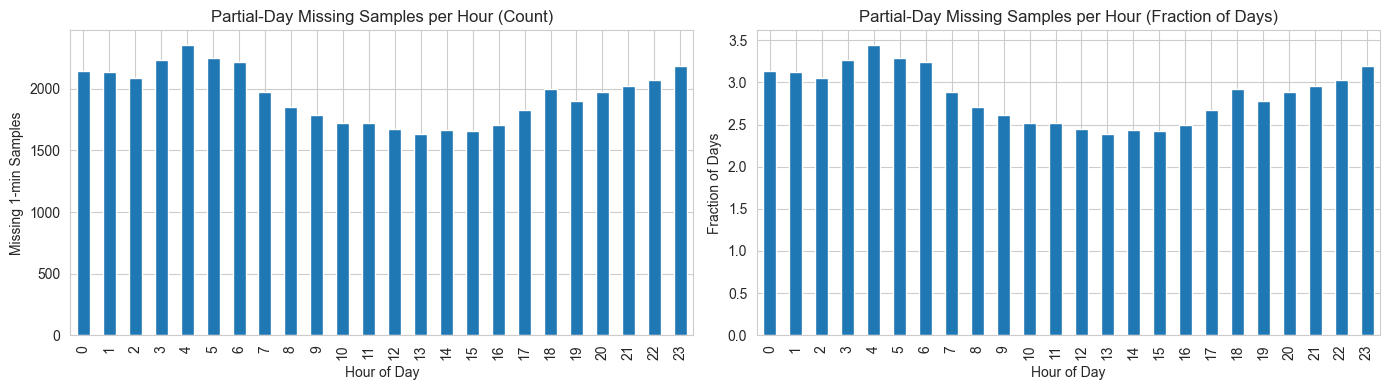

In [40]:
def plot_partial_missingness_patterns(df):
    """Plot missingness patterns using only partially missing days (excludes full-day gaps)."""

    print("\n🔍 Plotting Missingness (Excluding Fully Missing Days)...")

    # Setup full expected timeline and identify missing
    start, end = df.index.min(), df.index.max()
    full_idx = pd.date_range(start, end, freq='min')
    actual_idx = df.index.unique().sort_values()
    missing_idx = full_idx.difference(actual_idx)

    # Daily missing counts
    missing_per_day = pd.Series(1, index=missing_idx).groupby(missing_idx.date).count()
    full_days_missing = missing_per_day[missing_per_day == 1440].index

    # Filter missing to exclude 100% missing days
    partial_missing_idx = missing_idx[~missing_idx.normalize().isin(full_days_missing)]

    # Hourly counts and fractions
    n_partial_days = len(missing_per_day[missing_per_day < 1440])
    miss_per_hour = pd.Series(1, index=partial_missing_idx).groupby(partial_missing_idx.hour).count()
    miss_frac_hour = miss_per_hour / n_partial_days

    # Plot: Count and fraction of missing samples per hour
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    miss_per_hour.plot.bar(ax=axes[0])
    axes[0].set_title("Partial-Day Missing Samples per Hour (Count)")
    axes[0].set_xlabel("Hour of Day")
    axes[0].set_ylabel("Missing 1-min Samples")

    miss_frac_hour.plot.bar(ax=axes[1])
    axes[1].set_title("Partial-Day Missing Samples per Hour (Fraction of Days)")
    axes[1].set_xlabel("Hour of Day")
    axes[1].set_ylabel("Fraction of Days")

    plt.tight_layout()
    plt.show()

    # Return stats if needed
    return {
        'partial_missing_idx': partial_missing_idx,
        'missing_per_hour': miss_per_hour,
        'missing_frac_hour': miss_frac_hour,
        'n_partial_days': n_partial_days
    }

# Run it
partial_results = plot_partial_missingness_patterns(df)


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_22752/1228361238.py:13: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  partial_missing_idx = missing_idx[~missing_idx.normalize().isin(full_days_missing)]


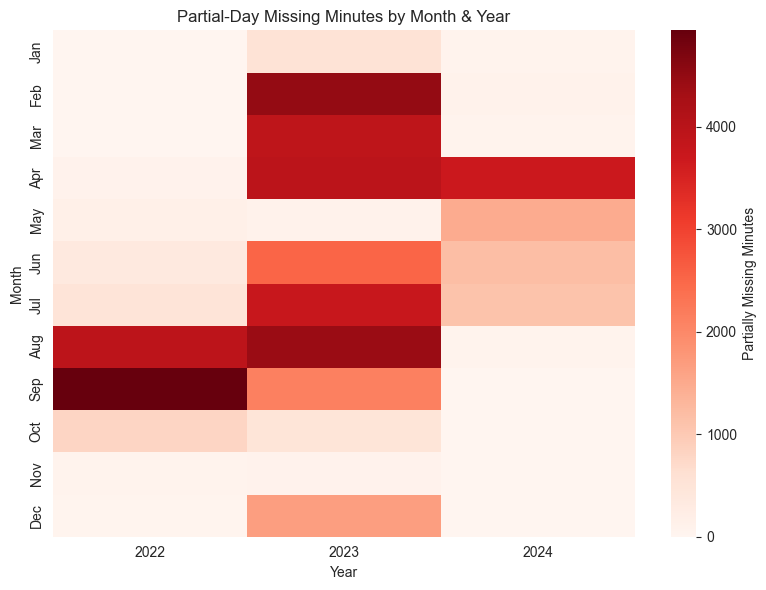

In [41]:
def plot_partial_monthly_missing_heatmap(df):
    """Monthly × Year heatmap showing only partially missing days (excludes full-day outages)."""

    # Step 1: Identify missing timestamps
    start, end = df.index.min(), df.index.max()
    full_idx = pd.date_range(start, end, freq='min')
    actual_idx = df.index.unique().sort_values()
    missing_idx = full_idx.difference(actual_idx)

    # Step 2: Identify and exclude full missing days
    missing_per_day = pd.Series(1, index=missing_idx).groupby(missing_idx.date).count()
    full_days_missing = missing_per_day[missing_per_day == 1440].index
    partial_missing_idx = missing_idx[~missing_idx.normalize().isin(full_days_missing)]

    # Step 3: Build monthly-year pivot only from partial missing timestamps
    miss_df = pd.DataFrame(index=partial_missing_idx)
    miss_df['year'] = miss_df.index.year
    miss_df['month'] = miss_df.index.month

    pivot_my = miss_df.groupby(['month', 'year']).size().unstack(fill_value=0)

    # Step 4: Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        pivot_my,
        cmap='Reds',
        cbar_kws={'label': 'Partially Missing Minutes'},
        yticklabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    )
    plt.title("Partial-Day Missing Minutes by Month & Year")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.tight_layout()
    plt.show()

    return pivot_my

# Run it
partial_monthly_heatmap = plot_partial_monthly_missing_heatmap(df)


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_22752/1693266170.py:15: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  partial_missing_idx = missing_idx[~missing_idx.normalize().isin(full_days_missing)]



🔍 Analyzing Ethiopian seasonal missing patterns (excluding fully missing days)...


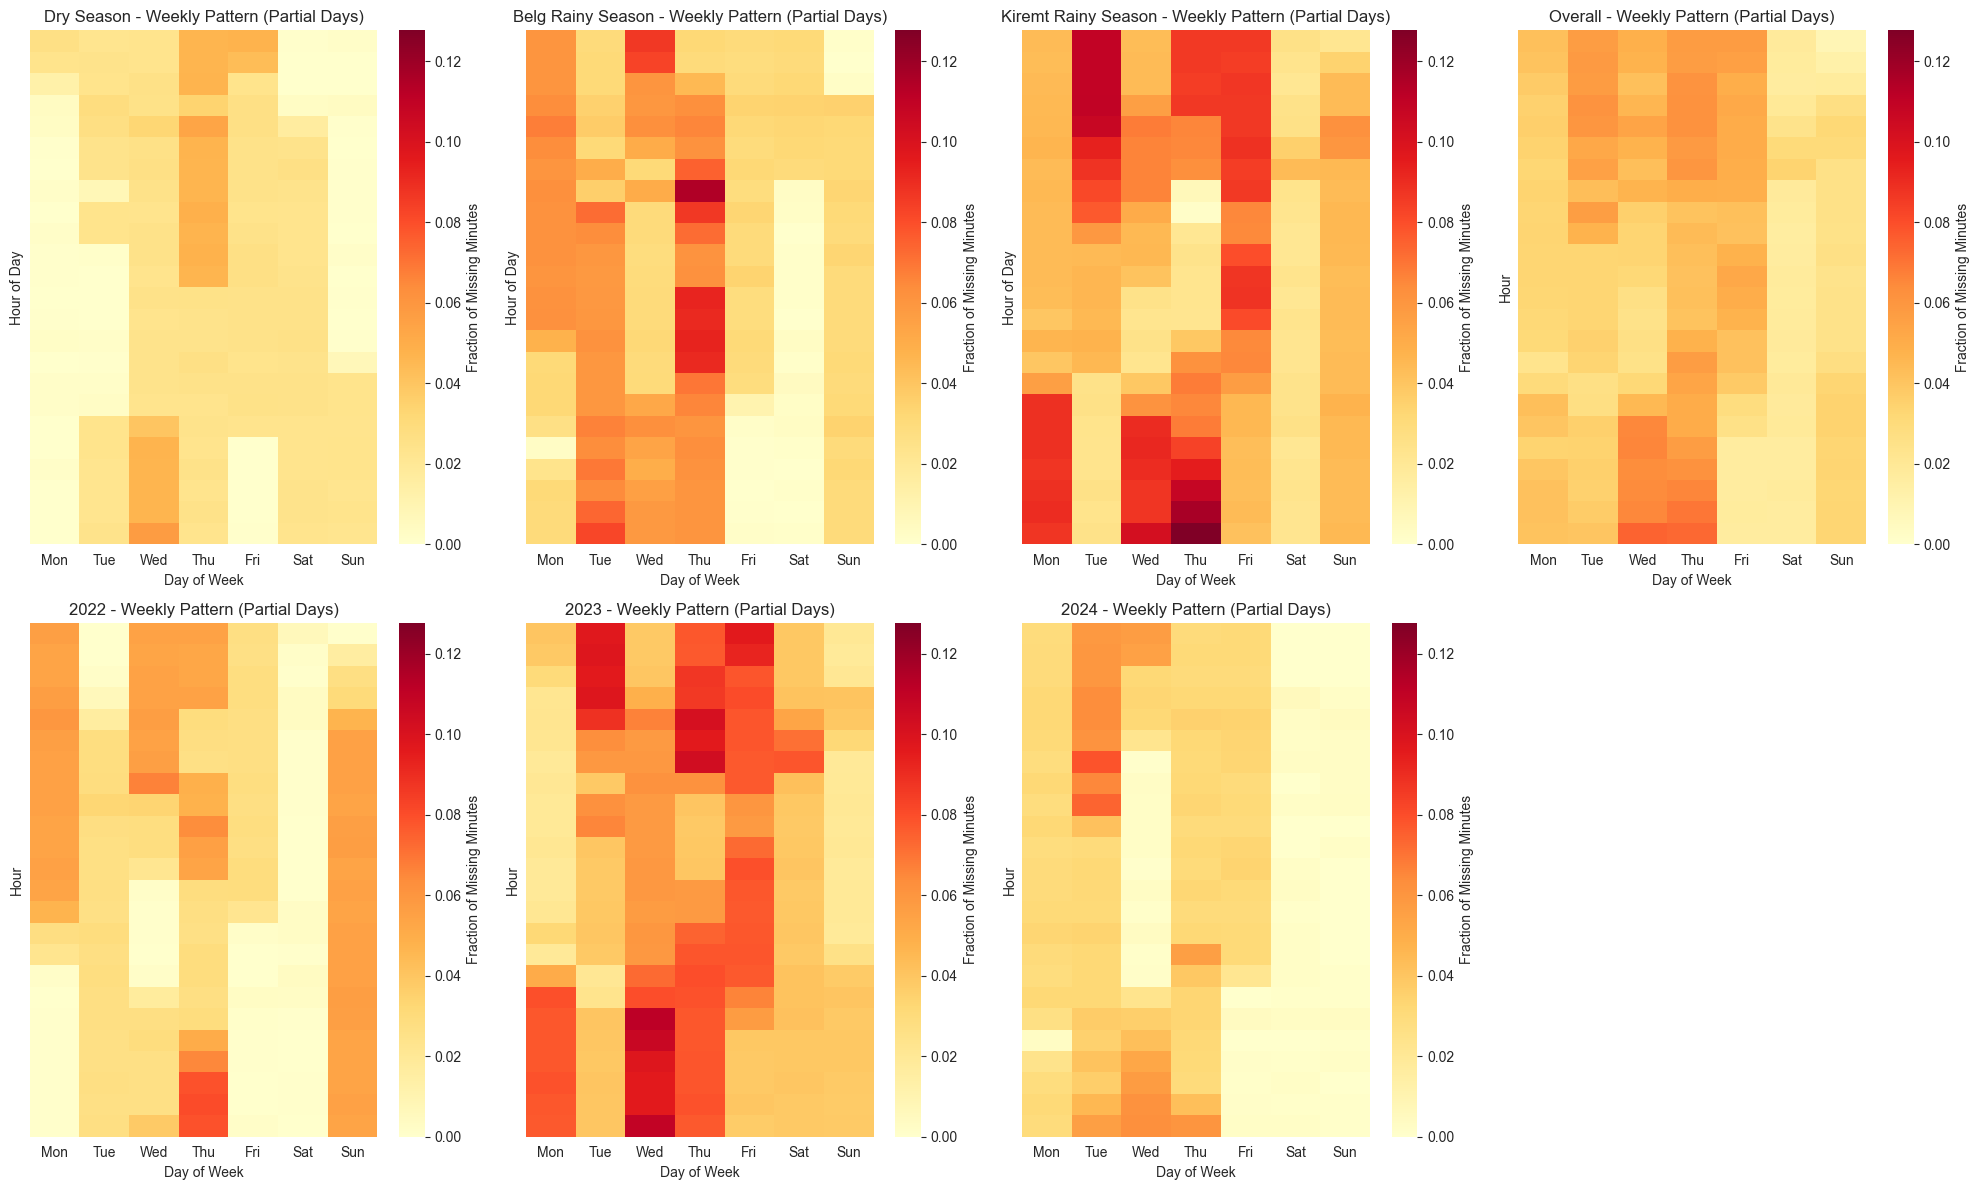

In [42]:
def analyze_partial_missingness_by_season_week(df):
    """Analyze weekly diurnal missing patterns for *partially* missing days only."""

    print("\n🔍 Analyzing Ethiopian seasonal missing patterns (excluding fully missing days)...")

    # Full and actual index
    start, end = df.index.min(), df.index.max()
    full_idx = pd.date_range(start, end, freq='min')
    actual_idx = df.index.unique().sort_values()
    missing_idx = full_idx.difference(actual_idx)

    # Exclude 100% missing days
    missing_per_day = pd.Series(1, index=missing_idx).groupby(missing_idx.date).count()
    full_days_missing = missing_per_day[missing_per_day == 1440].index
    partial_missing_idx = missing_idx[~missing_idx.normalize().isin(full_days_missing)]

    # Mark missing only for partial-missing days
    miss_df = pd.DataFrame(index=full_idx)
    miss_df['is_missing'] = 0
    miss_df.loc[partial_missing_idx, 'is_missing'] = 1

    # Add time features
    miss_df['Hour'] = miss_df.index.hour
    miss_df['DayOfWeek'] = miss_df.index.dayofweek
    miss_df['Month'] = miss_df.index.month
    miss_df['Year'] = miss_df.index.year
    miss_df['Ethiopian_Season'] = miss_df['Month'].map(map_ethiopian_seasons)

    # Categories
    seasons = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    years = sorted(miss_df['Year'].unique())

    # Pivot tables
    season_pivots = {
        season: miss_df[miss_df['Ethiopian_Season'] == season]
            .pivot_table(index='Hour', columns='DayOfWeek', values='is_missing', aggfunc='mean')
        for season in seasons
    }

    year_pivots = {
        year: miss_df[miss_df['Year'] == year]
            .pivot_table(index='Hour', columns='DayOfWeek', values='is_missing', aggfunc='mean')
        for year in years
    }

    overall_pivot = miss_df.pivot_table(index='Hour', columns='DayOfWeek', values='is_missing', aggfunc='mean')

    # Color scale
    all_pivots = list(season_pivots.values()) + list(year_pivots.values()) + [overall_pivot]
    vmax = max(p.max().max() for p in all_pivots)

    # Plotting
    fig, axes = plt.subplots(2, 4, figsize=(20, 12), sharey=True)
    axes = axes.flatten()

    # Plot each season
    for i, season in enumerate(seasons):
        sns.heatmap(
            season_pivots[season], ax=axes[i],
            cmap='YlOrRd', vmin=0, vmax=vmax,
            xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
            yticklabels=[f'{h:02d}:00' for h in range(24)],
            cbar_kws={'label': 'Fraction of Missing Minutes'}
        )
        axes[i].set_title(f"{season} - Weekly Pattern (Partial Days)")
        axes[i].set_xlabel("Day of Week")
        axes[i].set_ylabel("Hour of Day")

    # Overall plot
    sns.heatmap(
        overall_pivot, ax=axes[3],
        cmap='YlOrRd', vmin=0, vmax=vmax,
        xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
        yticklabels=False,
        cbar_kws={'label': 'Fraction of Missing Minutes'}
    )
    axes[3].set_title("Overall - Weekly Pattern (Partial Days)")
    axes[3].set_xlabel("Day of Week")

    # Plot each year
    for j, year in enumerate(years):
        if 4 + j >= len(axes):
            break
        sns.heatmap(
            year_pivots[year], ax=axes[4 + j],
            cmap='YlOrRd', vmin=0, vmax=vmax,
            xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
            yticklabels=False,
            cbar_kws={'label': 'Fraction of Missing Minutes'}
        )
        axes[4 + j].set_title(f"{year} - Weekly Pattern (Partial Days)")
        axes[4 + j].set_xlabel("Day of Week")

    # Hide unused axes
    for k in range(4 + len(years), len(axes)):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()

    return {
        'seasonal_pivots': season_pivots,
        'yearly_pivots': year_pivots,
        'overall': overall_pivot
    }

# Run it
partial_seasonal_results = analyze_partial_missingness_by_season_week(df)



⏰ Analyzing Diurnal Missingness (Partial Days Only)...


/var/folders/5y/nymdg1zj29dglz6b4sf4v02c0000gn/T/ipykernel_22752/2351697173.py:15: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  partial_missing_idx = missing_idx[~missing_idx.normalize().isin(full_days_missing)]


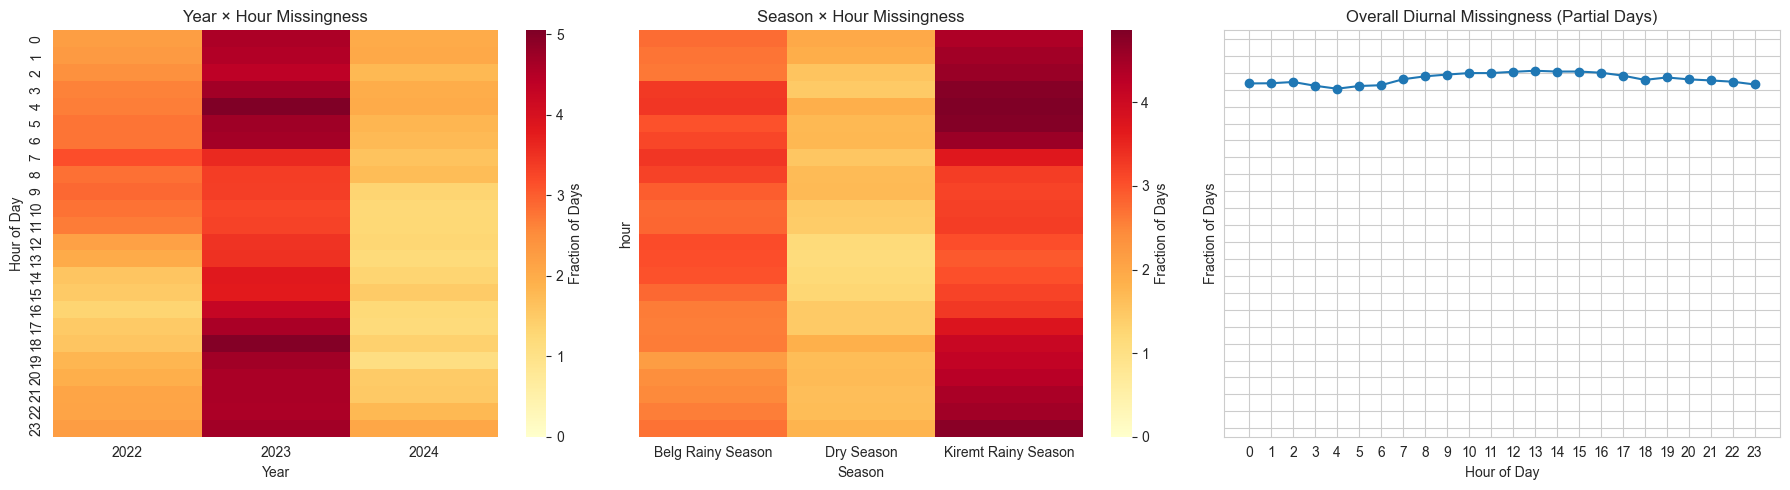

In [43]:
def analyze_partial_diurnal_missingness_by_season_and_year(df):
    """Plot diurnal (hourly) missingness by Ethiopian season and year, using only partial-missing days."""

    print("\n⏰ Analyzing Diurnal Missingness (Partial Days Only)...")

    # Step 1: Build expected and missing timeline
    start, end = df.index.min(), df.index.max()
    full_idx = pd.date_range(start, end, freq='min')
    actual_idx = df.index.unique().sort_values()
    missing_idx = full_idx.difference(actual_idx)

    # Step 2: Identify and exclude fully missing days
    missing_per_day = pd.Series(1, index=missing_idx).groupby(missing_idx.date).count()
    full_days_missing = missing_per_day[missing_per_day == 1440].index
    partial_missing_idx = missing_idx[~missing_idx.normalize().isin(full_days_missing)]

    # Step 3: Create DataFrame of partial missing times
    miss_df = pd.DataFrame(index=partial_missing_idx)
    miss_df['hour'] = miss_df.index.hour
    miss_df['year'] = miss_df.index.year
    miss_df['month'] = miss_df.index.month
    miss_df['season'] = miss_df['month'].map(map_ethiopian_seasons)

    # Step 4: Days per year and per season (excluding fully missing days)
    all_partial_days = pd.Series(1, index=partial_missing_idx.normalize()).groupby(partial_missing_idx.date).first()

    # Convert to datetime for grouping
    partial_dates = pd.to_datetime(all_partial_days.index)
    days_per_year = partial_dates.to_series().groupby(partial_dates.year).nunique()
    days_per_season = partial_dates.to_series().groupby(partial_dates.month.map(map_ethiopian_seasons)).nunique()
        


    # Step 5: Aggregate missingness per hour
    days_missing_by_yh = miss_df.groupby(['year', 'hour']).size().unstack(level=0).fillna(0)
    days_missing_by_sh = miss_df.groupby(['season', 'hour']).size().unstack(level=0).fillna(0)
    total_missing_by_hour = miss_df['hour'].value_counts().sort_index()

    # Normalize to get fraction of days with missing in each hour
    frac_yh = days_missing_by_yh.div(days_per_year, axis=1)
    frac_sh = days_missing_by_sh.div(days_per_season, axis=1)
    frac_hour_overall = total_missing_by_hour / len(all_partial_days)

    # Step 6: Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    sns.heatmap(frac_yh, cmap='YlOrRd', ax=ax1,
                cbar_kws={'label': 'Fraction of Days'},
                vmin=0, vmax=frac_yh.max().max())
    ax1.set_title("Year × Hour Missingness")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Hour of Day")

    sns.heatmap(frac_sh, cmap='YlOrRd', ax=ax2,
                cbar_kws={'label': 'Fraction of Days'},
                vmin=0, vmax=frac_sh.max().max())
    ax2.set_title("Season × Hour Missingness")
    ax2.set_xlabel("Season")

    ax3.plot(frac_hour_overall.index, frac_hour_overall.values, marker='o')
    ax3.set_xticks(range(24))
    ax3.set_title("Overall Diurnal Missingness (Partial Days)")
    ax3.set_xlabel("Hour of Day")
    ax3.set_ylabel("Fraction of Days")
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

    # Return DataFrames if needed
    return {
        'frac_by_year_hour': frac_yh,
        'frac_by_season_hour': frac_sh,
        'frac_overall_hour': frac_hour_overall
    }

# Run it
diurnal_partial_results = analyze_partial_diurnal_missingness_by_season_and_year(df)


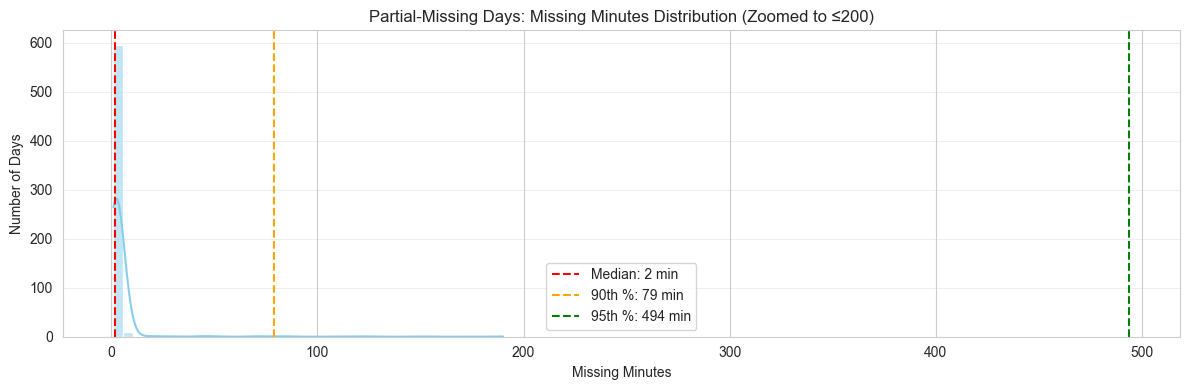

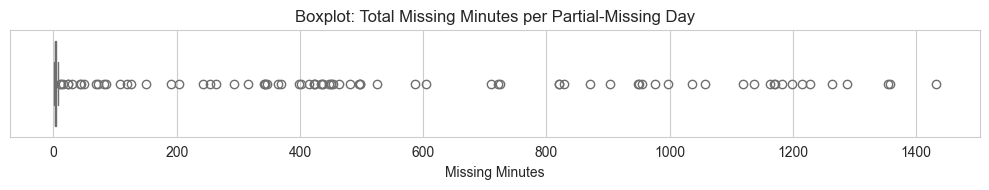


📊 Summary (Partial-Missing Days):
• Total partial-missing days: 684
• Mean: 68.4 min
• Median: 2.0 min
• Std dev: 230.0 min
• 90th percentile: 79 min
• 95th percentile: 494 min
• Max: 1432 min


In [44]:
def plot_better_partial_missing_distribution(df):
    """Improved visualization of missing minutes per partial-missing day."""

    # Step 1: Identify partial-missing days
    start, end = df.index.min(), df.index.max()
    full_idx = pd.date_range(start, end, freq='min')
    actual_idx = df.index.unique().sort_values()
    missing_idx = full_idx.difference(actual_idx)

    missing_per_day = pd.Series(1, index=missing_idx).groupby(missing_idx.date).count()
    partial_missing = missing_per_day[missing_per_day < 1440]

    # Step 2: Stats
    q90 = partial_missing.quantile(0.90)
    q95 = partial_missing.quantile(0.95)

    # Step 3: Histogram (Zoomed)
    plt.figure(figsize=(12, 4))
    sns.histplot(partial_missing[partial_missing <= 200], bins=40, kde=True, color='skyblue')
    plt.axvline(partial_missing.median(), color='red', linestyle='--', label=f"Median: {partial_missing.median():.0f} min")
    plt.axvline(q90, color='orange', linestyle='--', label=f"90th %: {q90:.0f} min")
    plt.axvline(q95, color='green', linestyle='--', label=f"95th %: {q95:.0f} min")
    plt.title("Partial-Missing Days: Missing Minutes Distribution (Zoomed to ≤200)")
    plt.xlabel("Missing Minutes")
    plt.ylabel("Number of Days")
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Step 4: Boxplot
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=partial_missing, color='lightcoral')
    plt.title("Boxplot: Total Missing Minutes per Partial-Missing Day")
    plt.xlabel("Missing Minutes")
    plt.tight_layout()
    plt.show()

    # Step 5: Summary
    print("\n📊 Summary (Partial-Missing Days):")
    print(f"• Total partial-missing days: {len(partial_missing)}")
    print(f"• Mean: {partial_missing.mean():.1f} min")
    print(f"• Median: {partial_missing.median():.1f} min")
    print(f"• Std dev: {partial_missing.std():.1f} min")
    print(f"• 90th percentile: {q90:.0f} min")
    print(f"• 95th percentile: {q95:.0f} min")
    print(f"• Max: {partial_missing.max():.0f} min")

    return partial_missing

partial_cleaned = plot_better_partial_missing_distribution(df)


In [45]:
def classify_partial_missing_days(df):
    """Classify and plot partial-missing days into quality levels (emoji-safe version)."""

    # Step 1: Recompute missing per day
    start, end = df.index.min(), df.index.max()
    full_idx = pd.date_range(start, end, freq='min')
    actual_idx = df.index.unique().sort_values()
    missing_idx = full_idx.difference(actual_idx)

    missing_per_day = pd.Series(1, index=missing_idx).groupby(missing_idx.date).count()
    partial_missing = missing_per_day[missing_per_day < 1440]

    # Step 2: Classification
    def label_quality(missing):
        if missing <= 10:
            return 'Excellent'
        elif missing <= 60:
            return 'Good'
        elif missing <= 240:
            return 'Moderate'
        else:
            return 'Poor'

    quality_labels = partial_missing.apply(label_quality)
    counts = quality_labels.value_counts().reindex(['Excellent', 'Good', 'Moderate', 'Poor'], fill_value=0)

    # Step 3: Plot
    quality_df = counts.reset_index()
    quality_df.columns = ['quality', 'count']

    plt.figure(figsize=(8, 4))
    sns.barplot(data=quality_df, x='quality', y='count', hue='quality',
                palette=['green', 'blue', 'orange', 'red'], legend=False)
    plt.title("Data Quality of Partial-Missing Days")
    plt.ylabel("Number of Days")
    plt.xlabel("Quality Category")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Step 4: Summary
    print("\n📊 Partial-Missing Day Quality Summary:")
    for label, count in counts.items():
        print(f"{label}: {count} days")

    return quality_labels


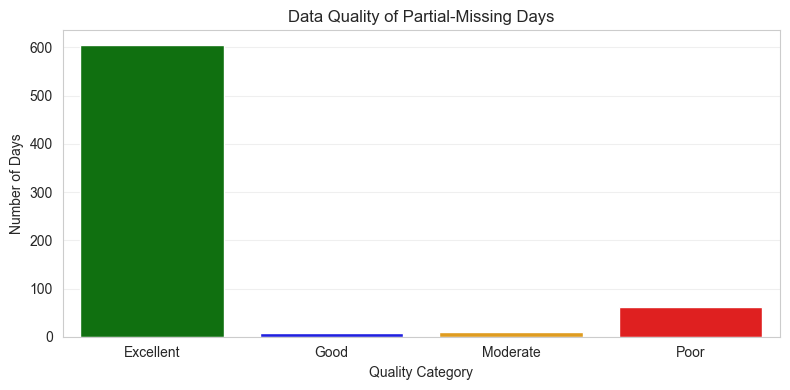


📊 Partial-Missing Day Quality Summary:
Excellent: 605 days
Good: 8 days
Moderate: 10 days
Poor: 61 days


In [46]:
quality_by_day = classify_partial_missing_days(df)


# ⓫ Overlap Filter-Sample Days with High-Quality Aethalometer Data
The goal is to keep **only those 24-h filter (FTIR/HIPS) samples that  
were collected on days when the Aethalometer minute stream is "Excellent"  
(≤ 10 min missing) or "Good" (11–60 min, ≤ 30 consecutive).  
These are the days we'll use for the EC-BC comparison and MAC work.

In [47]:
def load_filter_sample_data():
    """Load ETAD (HIPS) and FTIR data from SQLite database."""
    print("Loading ETAD (HIPS) and FTIR filter sample data from database...")
    
    # Define database path - update this to your actual path
    db_path = '/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/Combined Database/spartan_ftir_hips.db'
    
    try:
        # Connect to the database
        conn = sqlite3.connect(db_path)
        
        # Load HIPS/FTIR data for the ETAD site
        query = """
        SELECT f.filter_id, 
               f.sample_date AS SampleDate, 
               m.ec_ftir AS EC_FTIR,
               m.oc_ftir AS OC_FTIR,
               m.fabs AS Fabs,
               f.site_code AS Site
        FROM filters f
        JOIN ftir_sample_measurements m USING(filter_id)
        WHERE f.site_code = 'ETAD'
        ORDER BY f.sample_date;
        """
        
        # Execute the query and load into a DataFrame
        combined_data = pd.read_sql_query(query, conn)
        
        # Convert date column to datetime
        combined_data['SampleDate'] = pd.to_datetime(combined_data['SampleDate'])
        
        # For compatibility with existing code, create separate dataframes for HIPS and FTIR
        # Both dataframes contain the same data since they're joined in the database
        etad_data = combined_data.copy()
        ftir_data = combined_data.copy()
        ftir_data.rename(columns={'SampleDate': 'date'}, inplace=True)
        
        # Display summary
        valid_hips_count = etad_data['SampleDate'].notna().sum()
        valid_ftir_count = ftir_data['date'].notna().sum()
        
        print(f"Loaded {len(etad_data)} ETAD samples from database ({valid_hips_count} with valid dates)")
        print(f"  - All filter samples have both HIPS and FTIR measurements")
        
        # Close the connection
        conn.close()
        
    except Exception as e:
        print(f"❌ Error loading database: {e}")
        print("Creating empty dataframes as fallback...")
        etad_data = pd.DataFrame(columns=['filter_id', 'SampleDate', 'Fabs', 'Site'])
        ftir_data = pd.DataFrame(columns=['filter_id', 'date', 'EC_FTIR', 'OC_FTIR'])
    
    return etad_data, ftir_data

In [48]:
def classify_aethalometer_9to9_periods(df, quality_by_day=None):
    """
    Re-classify aethalometer data quality based on 9am-to-9am periods to match filter sampling.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The original aethalometer DataFrame with datetime index
    quality_by_day : pandas.Series, optional
        If provided, use the existing daily classifications (midnight-to-midnight)
        and remap them to 9am-to-9am periods
    
    Returns:
    --------
    pandas.Series
        Series with datetime index (9am) and quality label values
    """
    print("\n⏰ Classifying aethalometer data quality based on 9am-to-9am sampling periods...")
    
    if quality_by_day is None:
        print("No daily quality classifications provided. Creating from scratch...")
        
        # Define expected full-minute timeline
        full_idx = pd.date_range(df.index.min(), df.index.max(), freq='min')
        actual_idx = df.index.unique().sort_values()
        missing_idx = full_idx.difference(actual_idx)
        
        # Now we'll classify based on 9am-to-9am periods
        # Shift each timestamp to the previous 9am boundary
        nine_am_periods = full_idx.map(lambda ts: 
            ts.normalize() + pd.Timedelta(hours=9) if ts.hour < 9 
            else ts.normalize() + pd.Timedelta(hours=9) + pd.Timedelta(days=1)
        )
        
        # Same for missing timestamps
        missing_nine_am_periods = missing_idx.map(lambda ts: 
            ts.normalize() + pd.Timedelta(hours=9) if ts.hour < 9 
            else ts.normalize() + pd.Timedelta(hours=9) + pd.Timedelta(days=1)
        )
        
        # Count missing minutes per 9am-to-9am period
        missing_per_period = pd.Series(1, index=missing_nine_am_periods).groupby(level=0).count()
        
        # Classify quality based on missing minutes
        def label_quality(missing):
            if missing <= 10:
                return 'Excellent'
            elif missing <= 60:
                return 'Good'
            elif missing <= 240:
                return 'Moderate'
            else:
                return 'Poor'
                
        quality_by_period = missing_per_period.apply(label_quality)
        
    else:
        print("Using existing daily quality classifications and remapping to 9am-to-9am periods...")
        
        # Convert index to datetime if it's a date
        if isinstance(quality_by_day.index[0], pd.Timestamp):
            date_index = quality_by_day.index
        else:
            date_index = pd.to_datetime(quality_by_day.index)
        
        # Create a new Series with timestamp index at midnight
        midnight_series = pd.Series(quality_by_day.values, index=date_index)
        
        # Map each 9am-to-9am period to a midnight-to-midnight "day"
        # A 9am-to-9am period spanning day N and N+1 will be classified based on day N
        result = {}
        
        for date in date_index:
            # The 9am timestamp that starts this sampling period
            period_start = date.normalize() + pd.Timedelta(hours=9)
            
            # Get the quality label for this date
            quality = midnight_series.loc[date]
            
            # Assign to result
            result[period_start] = quality
        
        # Convert to Series
        quality_by_period = pd.Series(result)
        quality_by_period.index = pd.DatetimeIndex(quality_by_period.index)
        quality_by_period = quality_by_period.sort_index()
    
    # Display stats
    quality_counts = quality_by_period.value_counts()
    print(f"\n• Total 9am-to-9am periods classified: {len(quality_by_period)}")
    print("• Quality distribution:")
    for quality, count in quality_counts.items():
        print(f"  - {quality}: {count} periods ({count/len(quality_by_period)*100:.1f}%)")
    
    return quality_by_period

In [49]:
def analyze_filter_sample_quality_overlap(quality_by_period, etad_data, ftir_data):
    """
    Analyze the overlap between high-quality 9am-to-9am aethalometer periods and filter samples.
    For the database version, all samples already have both FTIR and HIPS measurements.
    
    Parameters:
    -----------
    quality_by_period : pandas.Series
        Series with datetime index (9am) and quality label values
    etad_data : pandas.DataFrame
        DataFrame containing sample data with 'SampleDate' column
    ftir_data : pandas.DataFrame
        DataFrame containing sample data with 'date' column (same as etad_data in DB version)
    
    Returns:
    --------
    dict
        Dictionary containing overlap information and statistics
    """
    print("\n📊 Analyzing overlap between filter samples and high-quality 9am-to-9am periods...")
    
    # 1. Get high-quality periods (Excellent or Good)
    high_quality_mask = quality_by_period.isin(['Excellent', 'Good'])
    high_quality_periods = quality_by_period[high_quality_mask].index
    excellent_periods = quality_by_period[quality_by_period == 'Excellent'].index
    good_periods = quality_by_period[quality_by_period == 'Good'].index
    
    print(f"• Total 9am-to-9am periods in analysis: {len(quality_by_period)}")
    print(f"• High-quality periods (Excellent or Good): {len(high_quality_periods)} "
          f"({len(high_quality_periods)/len(quality_by_period)*100:.1f}% of total)")
    print(f"  - Excellent periods (≤10 min missing): {len(excellent_periods)}")
    print(f"  - Good periods (11-60 min missing): {len(good_periods)}")
    
    # 2. Get filter sample dates and convert to 9am start time
    # These dates typically represent when the filters were collected (end of 24h sampling)
    # We need to convert to the start time (24h earlier)
    
    # For database version, just use etad_data since it already has both measurements
    valid_sample_dates = etad_data['SampleDate'].dropna()
    filter_dates = pd.DatetimeIndex([
        d.normalize() + pd.Timedelta(hours=9)
        for d in valid_sample_dates
    ])
    
    print(f"• Total filter sample periods: {len(filter_dates.unique())}")
    print(f"• In database version, all filter samples have both HIPS and FTIR measurements")
    
    # 3. Since all samples have both HIPS and FTIR in the database, we can simplify this
    filter_periods = filter_dates.unique()
    print(f"• Total unique filter periods for analysis: {len(filter_periods)}")
    
    # Handle the case when no filter periods are found
    if len(filter_periods) == 0:
        print("⚠️ Warning: No filter periods found. Database might be empty or path incorrect.")
        # Create a dummy filter quality table
        filter_quality_table = pd.DataFrame(columns=['Count', 'Percentage'])
        
        # Return empty results with the necessary structure
        return {
            'high_quality_periods': high_quality_periods,
            'excellent_periods': excellent_periods,
            'good_periods': good_periods,
            'filter_periods': pd.DatetimeIndex([]),
            'overlap_periods': pd.DatetimeIndex([]),
            'excellent_overlaps': pd.DatetimeIndex([]),
            'good_overlaps': pd.DatetimeIndex([]),
            'hips_high_quality_overlaps': pd.DatetimeIndex([]),
            'ftir_high_quality_overlaps': pd.DatetimeIndex([]),
            'hips_ftir_overlap': pd.DatetimeIndex([]),
            'filter_quality_table': filter_quality_table,
            'hips_dates': pd.DatetimeIndex([]),
            'ftir_dates': pd.DatetimeIndex([]),
            'quality_by_period': quality_by_period
        }
    
    # 4. Find overlaps with high-quality aethalometer data
    overlap_periods = pd.DatetimeIndex(filter_periods).intersection(high_quality_periods)
    excellent_overlaps = pd.DatetimeIndex(filter_periods).intersection(excellent_periods)
    good_overlaps = pd.DatetimeIndex(filter_periods).intersection(good_periods)
    
    print(f"\n• Filter samples with high-quality data: {len(overlap_periods)} "
          f"({len(overlap_periods)/len(filter_periods)*100:.1f}% of filter samples)")
    print(f"  - With Excellent data (≤10 min missing): {len(excellent_overlaps)}")
    print(f"  - With Good data (11-60 min missing): {len(good_overlaps)}")
    
    # 5. To maintain compatibility with the rest of the code, we set both HIPS and FTIR dates
    # to the same filter_periods, as they are the same in the database approach
    hips_dates = filter_dates
    ftir_dates = filter_dates
    hips_ftir_overlap = filter_dates  # All samples have both in DB version
    
    # 6. Calculate quality distribution of filter sample periods
    filter_period_qualities = []
    for period in filter_periods:
        if period in quality_by_period.index:
            filter_period_qualities.append(quality_by_period.loc[period])
        else:
            filter_period_qualities.append('No Data')
    
    quality_counts = pd.Series(filter_period_qualities).value_counts()
    quality_pcts = quality_counts / len(filter_periods) * 100
    
    filter_quality_table = pd.DataFrame({
        'Count': quality_counts,
        'Percentage': quality_pcts.round(1)
    })
    
    print("\n• Quality distribution of filter sample periods:")
    display(filter_quality_table)
    
    # Return results dictionary for further analysis
    return {
        'high_quality_periods': high_quality_periods,
        'excellent_periods': excellent_periods,
        'good_periods': good_periods,
        'filter_periods': filter_periods,
        'overlap_periods': overlap_periods,
        'excellent_overlaps': excellent_overlaps,
        'good_overlaps': good_overlaps,
        'hips_high_quality_overlaps': overlap_periods,  # Same as overlap_periods in DB version
        'ftir_high_quality_overlaps': overlap_periods,  # Same as overlap_periods in DB version
        'hips_ftir_overlap': filter_periods,  # All samples have both in DB version
        'filter_quality_table': filter_quality_table,
        'hips_dates': hips_dates,  # Same as filter_dates in DB version
        'ftir_dates': ftir_dates,  # Same as filter_dates in DB version
        'quality_by_period': quality_by_period
    }

In [50]:
def analyze_both_filters_quality(results, include_no_data_in_percentages=False):
    """
    Create a detailed analysis focusing on periods with both HIPS and FTIR filters.
    
    Parameters:
    -----------
    results : dict
        Dictionary with overlap results from analyze_filter_sample_quality_overlap
    include_no_data_in_percentages : bool, default=False
        If True, include "No Data" periods when calculating percentages.
        If False, calculate percentages based only on periods with data.
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with quality information for periods with both filter types
    """
    print("\n🔍 Analyzing periods with both HIPS and FTIR filter samples...")
    
    # Get periods with both filter types
    hips_ftir_overlap = results.get('hips_ftir_overlap', pd.DatetimeIndex([]))
    
    if len(hips_ftir_overlap) == 0:
        print("ℹ️ With the database approach, all samples have both HIPS and FTIR measurements.")
        # Use all filter periods since they all have both measurements
        hips_ftir_overlap = results.get('filter_periods', pd.DatetimeIndex([]))
    
    print(f"• Found {len(hips_ftir_overlap)} periods with both HIPS and FTIR samples")
    
    # Create a DataFrame for these periods
    both_filters_df = pd.DataFrame(index=hips_ftir_overlap)
    both_filters_df['date'] = both_filters_df.index.date
    both_filters_df['start_time'] = both_filters_df.index
    both_filters_df['end_time'] = both_filters_df['start_time'] + pd.Timedelta(days=1)
    
    # Add quality information
    both_filters_df['quality'] = 'No Data'
    
    # Mark quality categories
    quality_by_period = results.get('quality_by_period', pd.Series())
    
    for idx in both_filters_df.index:
        if idx in results['excellent_periods']:
            both_filters_df.loc[idx, 'quality'] = 'Excellent'
        elif idx in results['good_periods']:
            both_filters_df.loc[idx, 'quality'] = 'Good'
        elif len(quality_by_period) > 0 and idx in quality_by_period.index:
            if quality_by_period.loc[idx] == 'Moderate':
                both_filters_df.loc[idx, 'quality'] = 'Moderate'
            elif quality_by_period.loc[idx] == 'Poor':
                both_filters_df.loc[idx, 'quality'] = 'Poor'
    
    # Add high quality flag (Excellent or Good)
    both_filters_df['high_quality'] = both_filters_df['quality'].isin(['Excellent', 'Good'])
    
    # Count by quality
    quality_counts = both_filters_df['quality'].value_counts()
    
    # Calculate percentages either including or excluding "No Data" periods
    if include_no_data_in_percentages:
        # Original calculation - use all periods for percentage denominator
        total_for_pct = len(both_filters_df)
    else:
        # Modified calculation - exclude "No Data" periods from percentage denominator
        no_data_count = quality_counts.get('No Data', 0)
        total_for_pct = len(both_filters_df) - no_data_count
    
    print(f"\n• Quality distribution for periods with both filter types:")
    for quality, count in quality_counts.items():
        # Skip percentage calculation for "No Data" when not including them in percentages
        if not include_no_data_in_percentages and quality == 'No Data':
            print(f"  - {quality}: {count} periods")
        else:
            if total_for_pct > 0:  # Avoid division by zero
                print(f"  - {quality}: {count} periods ({count/total_for_pct*100:.1f}%)")
            else:
                print(f"  - {quality}: {count} periods (N/A%)")
    
    # If not including "No Data" in percentages, add a note about the calculation basis
    if not include_no_data_in_percentages and 'No Data' in quality_counts:
        print(f"\n  Note: Percentages calculated excluding {quality_counts.get('No Data', 0)} 'No Data' periods")
        print(f"  Periods with data: {total_for_pct}")
    
    # Count high-quality periods
    high_quality_count = both_filters_df['high_quality'].sum()
    if total_for_pct > 0:
        high_quality_pct = high_quality_count/total_for_pct*100 if not include_no_data_in_percentages else high_quality_count/len(both_filters_df)*100
        print(f"\n• Periods with both filter types and high-quality data: {high_quality_count} ({high_quality_pct:.1f}%)")
    else:
        print(f"\n• Periods with both filter types and high-quality data: {high_quality_count}")
    
    # Create a table of the high-quality periods
    high_quality_periods = both_filters_df[both_filters_df['high_quality']]
    if len(high_quality_periods) > 0:
        print(f"\n• Dates with both filter types and high-quality data (sorted chronologically):")
        high_quality_table = high_quality_periods[['date', 'quality']].copy()
        high_quality_table['day_of_week'] = high_quality_table.index.dayofweek.map({
            0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
            4: 'Friday', 5: 'Saturday', 6: 'Sunday'
        })
        high_quality_table = high_quality_table.sort_values('date')
        display(high_quality_table)
    
    # Create a plot showing the distribution by quality
    plt.figure(figsize=(10, 6))
    
    # Define colors for the quality categories
    colors = {
        'Excellent': '#1976d2',  # Blue
        'Good': '#388e3c',       # Green
        'Moderate': '#f57c00',   # Orange
        'Poor': '#d32f2f',       # Red
        'No Data': '#9e9e9e'     # Gray
    }
    
    # Create a bar chart
    quality_order = ['Excellent', 'Good', 'Moderate', 'Poor', 'No Data']
    quality_order = [q for q in quality_order if q in quality_counts.index]
    
    counts = quality_counts.reindex(quality_order)
    bar_colors = [colors[q] for q in counts.index]
    
    bars = plt.bar(counts.index, counts.values, color=bar_colors)
    
    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom')
    
    # Add percentage labels for everything except "No Data" if not including it in percentages
    if not include_no_data_in_percentages:
        for i, (quality, count) in enumerate(counts.items()):
            if quality != 'No Data' and total_for_pct > 0:
                pct = count / total_for_pct * 100
                bar = bars[i]
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height/2,
                        f'{pct:.1f}%', ha='center', va='center', color='white', fontweight='bold')
    
    plt.title('Quality Distribution for Periods with Both HIPS and FTIR Samples', fontsize=14)
    plt.xlabel('Quality Category', fontsize=12)
    plt.ylabel('Number of Periods', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    
    if not include_no_data_in_percentages and 'No Data' in quality_counts:
        plt.figtext(0.5, 0.01, f"Note: Percentages calculated excluding 'No Data' periods ({quality_counts.get('No Data', 0)} periods)",
                   ha='center', fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.show()
    
    # Create a monthly distribution plot
    both_filters_df['year'] = both_filters_df.index.year
    both_filters_df['month'] = both_filters_df.index.month
    
    # Count by month and quality
    monthly_counts = both_filters_df.groupby(['year', 'month', 'quality']).size().unstack(fill_value=0)
    
    # Plot monthly distribution
    if not monthly_counts.empty:
        plt.figure(figsize=(15, 8))
        
        # Flatten the index for plotting
        monthly_counts = monthly_counts.reset_index()
        monthly_counts['date'] = monthly_counts.apply(
            lambda x: pd.Timestamp(year=int(x['year']), month=int(x['month']), day=15), 
            axis=1
        )
        monthly_counts = monthly_counts.set_index('date').sort_index()
        
        # Plot stacked bar chart
        monthly_counts_plot = monthly_counts.drop(['year', 'month'], axis=1)
        
        # Reorder columns for consistent colors
        cols = [c for c in quality_order if c in monthly_counts_plot.columns]
        monthly_counts_plot = monthly_counts_plot[cols]
        
        ax = monthly_counts_plot.plot(
            kind='bar', 
            stacked=True, 
            figsize=(15, 6),
            color=[colors[q] for q in cols]
        )
        
        plt.title('Monthly Distribution of Periods with Both Filter Types', fontsize=14)
        plt.xlabel('Month', fontsize=12)
        plt.ylabel('Number of Periods', fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        
        # Format x-axis labels to show month and year
        date_labels = [d.strftime('%b %Y') for d in monthly_counts_plot.index]
        ax.set_xticklabels(date_labels, rotation=45, ha='right')
        
        # Add a legend
        plt.legend(title='Quality', loc='upper right')
        
        plt.tight_layout()
        plt.show()
    
    return both_filters_df

In [51]:
def improved_plot_filter_sample_calendar(results, site_name="ETAD"):
    """
    Create improved calendar heatmap showing filter samples and data quality.
    Uses markers instead of colors to make categories more distinguishable.
    
    Parameters:
    -----------
    results : dict
        Dictionary with overlap results from analyze_filter_sample_quality_overlap
    site_name : str
        Name of the site for the plot title
    """
    print("\n📅 Creating improved calendar visualization of filter samples and data quality...")
    
    # Create a date range covering the entire period
    periods = []
    for key in ['high_quality_periods', 'filter_periods']:
        if key in results and len(results[key]) > 0:
            periods.extend(results[key])
    
    if not periods:
        print("No periods to plot.")
        return None
    
    start_date = min(periods)
    end_date = max(periods)
    
    # Create date range and DataFrame
    date_range = pd.date_range(start_date, end_date, freq='D')
    calendar_df = pd.DataFrame(index=date_range)
    
    # Add columns for data types - match exactly by timestamp
    calendar_df['high_quality'] = calendar_df.index.isin(results['high_quality_periods']).astype(int)
    calendar_df['excellent'] = calendar_df.index.isin(results['excellent_periods']).astype(int)
    calendar_df['good'] = calendar_df.index.isin(results['good_periods']).astype(int)
    
    # Filter samples
    calendar_df['hips_sample'] = calendar_df.index.isin(results['hips_dates']).astype(int)
    calendar_df['ftir_sample'] = calendar_df.index.isin(results['ftir_dates']).astype(int)
    calendar_df['both_filters'] = calendar_df.index.isin(results.get('hips_ftir_overlap', [])).astype(int)
    calendar_df['filter_sample'] = ((calendar_df['hips_sample'] + calendar_df['ftir_sample']) > 0).astype(int)
    
    # Overlaps
    calendar_df['overlap'] = calendar_df.index.isin(results['overlap_periods']).astype(int)
    calendar_df['excellent_overlap'] = calendar_df.index.isin(results['excellent_overlaps']).astype(int)
    calendar_df['good_overlap'] = calendar_df.index.isin(results['good_overlaps']).astype(int)
    
    # Extract date components
    calendar_df['year'] = calendar_df.index.year
    calendar_df['month'] = calendar_df.index.month
    calendar_df['day'] = calendar_df.index.day
    
    # Define markers for different categories
    # This approach uses different marker shapes instead of just colors
    markers = {
        'Both Filters + Excellent': '★',  # Star for best category
        'Both Filters + Good': '✦',      # Another star variant
        'Both Filters': '◆',             # Diamond
        'Both Filters (Poor/Moderate Quality)': '◇',  # Empty diamond
        'Excellent Overlap': '●',        # Filled circle
        'Good Overlap': '◍',             # Semi-filled circle
        'HIPS Sample Only': '▲',         # Triangle
        'FTIR Sample Only': '▼',         # Inverted triangle
        'Filter Sample (Poor/Moderate Quality)': '○',  # Empty circle
        'Excellent': '•',                # Small dot
        'Good': '∙',                     # Smaller dot
        'Other': ''                      # Nothing
    }
    
    colors = {
        'Both Filters + Excellent': '#1a237e',  # Dark blue
        'Both Filters + Good': '#2e7d32',       # Dark green
        'Both Filters': '#9e9e9e',              # Medium gray
        'Both Filters (Poor/Moderate Quality)': '#616161',  # Darker gray
        'Excellent Overlap': '#42a5f5',         # Medium blue
        'Good Overlap': '#66bb6a',              # Medium green
        'HIPS Sample Only': '#9c27b0',          # Purple
        'FTIR Sample Only': '#ff9800',          # Orange
        'Filter Sample (Poor/Moderate Quality)': '#bdbdbd',  # Light gray
        'Excellent': '#bbdefb',                 # Very light blue
        'Good': '#c8e6c9',                      # Very light green
        'Other': '#f5f5f5'                      # Almost white
    }
    
    # Create a categorical column for the marker assignment
    def get_category(row):
        if row['both_filters'] == 1:
            if row['excellent_overlap'] == 1:
                return 'Both Filters + Excellent'
            elif row['good_overlap'] == 1:
                return 'Both Filters + Good'
            elif row['high_quality'] == 1:  # This shouldn't happen (would be overlap) but just in case
                return 'Both Filters'
            else:
                return 'Both Filters (Poor/Moderate Quality)'
        elif row['excellent_overlap'] == 1:
            return 'Excellent Overlap'
        elif row['good_overlap'] == 1:
            return 'Good Overlap'
        elif row['filter_sample'] == 1:
            if row['hips_sample'] == 1 and row['ftir_sample'] == 0:
                return 'HIPS Sample Only'
            elif row['hips_sample'] == 0 and row['ftir_sample'] == 1:
                return 'FTIR Sample Only' 
            else:
                return 'Filter Sample (Poor/Moderate Quality)'
        elif row['excellent'] == 1:
            return 'Excellent'
        elif row['good'] == 1:
            return 'Good'
        else:
            return 'Other'
    
    calendar_df['category'] = calendar_df.apply(get_category, axis=1)
    calendar_df['marker'] = calendar_df['category'].map(markers)
    calendar_df['color'] = calendar_df['category'].map(colors)
    
    # Count years in the dataset
    years = sorted(calendar_df['year'].unique())
    
    # Use different year ranges if there are many years
    if len(years) > 3:
        # Group by year range (e.g., 2020-2022, 2023-2024)
        year_groups = []
        current_group = []
        for year in years:
            current_group.append(year)
            if len(current_group) == 2:  # Group years in pairs
                year_groups.append(current_group)
                current_group = []
        if current_group:  # Don't forget the last group if it's not complete
            year_groups.append(current_group)
    else:
        # Just use individual years
        year_groups = [[year] for year in years]
    
    # Create a figure for each year group
    for year_group in year_groups:
        fig, axes = plt.subplots(len(year_group), 12, figsize=(20, 3.5 * len(year_group)))
        
        # If only one year in group, make axes 2D
        if len(year_group) == 1:
            axes = axes.reshape(1, -1)
        
        # Import calendar module for getting days in month
        import calendar
        
        # Loop through years and months in this group
        for i, year in enumerate(year_group):
            for j in range(12):  # 12 months
                month = j + 1
                
                # Get the month data
                month_data = calendar_df[(calendar_df['year'] == year) & 
                                         (calendar_df['month'] == month)]
                
                if len(month_data) == 0:
                    # No data for this month, hide the axis
                    axes[i, j].axis('off')
                    continue
                
                # Set up the calendar grid
                days_in_month = calendar.monthrange(year, month)[1]
                first_day = pd.Timestamp(year=year, month=month, day=1)
                first_weekday = first_day.weekday()  # Monday=0, Sunday=6
                
                # Create a light gray grid for the calendar
                ax = axes[i, j]
                
                # Set background color to very light gray
                ax.set_facecolor('#f9f9f9')
                
                # Configure the plot for a calendar layout
                ax.set_xlim(-0.5, 6.5)
                ax.set_ylim(-0.5, 5.5)
                ax.set_aspect('equal')
                
                # Remove axes and ticks
                ax.set_xticks([])
                ax.set_yticks([])
                
                # Add horizontal and vertical grid lines
                for x in range(7):
                    ax.axvline(x - 0.5, color='#e0e0e0', linewidth=1)
                for y in range(6):
                    ax.axhline(y - 0.5, color='#e0e0e0', linewidth=1)
                
                # Add day labels at the top
                day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
                for x, label in enumerate(day_labels):
                    ax.text(x, -0.3, label, ha='center', va='center', fontsize=8, color='#666666')
                
                # Fill in the calendar with day numbers and markers
                for day in range(1, days_in_month + 1):
                    date = pd.Timestamp(year=year, month=month, day=day)
                    weekday = date.weekday()
                    week = (day + first_weekday - 1) // 7
                    
                    # Add day number
                    ax.text(weekday, week, str(day), ha='center', va='center', fontsize=9, 
                           fontweight='bold', color='#333333')
                    
                    # Add marker if this date has data
                    if date in month_data.index:
                        marker = month_data.loc[date, 'marker']
                        color = month_data.loc[date, 'color']
                        if marker:  # Only add if there's a marker
                            ax.text(weekday, week+0.25, marker, ha='center', va='center', 
                                   fontsize=14, color=color)
                
                # Set month name as title
                month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                              'July', 'August', 'September', 'October', 'November', 'December']
                ax.set_title(f"{month_names[month-1]} {year}", fontsize=11)
        
        # Add a legend for the markers
        marker_items = [(markers[cat], colors[cat], cat) for cat in markers.keys() if markers[cat]]
        
        # Create a separate legend axes below the calendar
        legend_ax = fig.add_axes([0.1, 0.02, 0.8, 0.05])
        legend_ax.axis('off')
        
        # Create the legend items
        for i, (marker, color, category) in enumerate(marker_items):
            # Calculate position (2 rows, 6 columns)
            row = i // 6
            col = i % 6
            x = 0.1 + (col * 0.15)
            y = 0.7 - (row * 0.5)
            
            # Add marker and text
            legend_ax.text(x, y, marker, fontsize=14, color=color, ha='center', va='center')
            legend_ax.text(x + 0.03, y, category, fontsize=9, color='black', ha='left', va='center')
        
        plt.suptitle(f"{site_name}: Filter Samples (9am-to-9am) and Aethalometer Data Quality - {year_group[0]}-{year_group[-1]}", 
                     fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0.1, 1, 0.95])
        plt.show()
    
    # Also return the dataframe for further analysis
    return calendar_df

In [52]:
def save_high_quality_filter_dates(results, output_path=None):
    """
    Save high-quality filter sample dates to a CSV file.
    
    Parameters:
    -----------
    results : dict
        Dictionary with overlap results from analyze_filter_sample_quality_overlap
    output_path : str, optional
        Path to save the CSV file. If None, use a default path.
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing the overlap dates with quality information
    """
    print("\n💾 Saving high-quality filter sample dates...")
    
    # Create a DataFrame with overlap dates - handle empty case
    if 'overlap_periods' not in results or len(results['overlap_periods']) == 0:
        print("⚠️ Warning: No overlap periods found.")
        return pd.DataFrame(columns=['start_time', 'end_time', 'quality', 'in_hips', 'in_ftir'])
    
    # Create the DataFrame with the overlap dates
    overlap_dates = pd.DataFrame(index=results['overlap_periods'])
    overlap_dates['start_time'] = overlap_dates.index
    
    # Calculate end time (24 hours later)
    overlap_dates['end_time'] = overlap_dates['start_time'] + pd.Timedelta(days=1)
    
    # Add quality column
    overlap_dates['quality'] = 'Good'  # Default quality
    
    # Mark excellent days
    excellent_mask = overlap_dates.index.isin(results['excellent_overlaps'])
    overlap_dates.loc[excellent_mask, 'quality'] = 'Excellent'
    
    # Sort by date
    overlap_dates = overlap_dates.sort_values('start_time')
    
    # Add columns indicating presence in HIPS and FTIR datasets
    overlap_dates['in_hips'] = overlap_dates.index.isin(results['hips_dates'])
    overlap_dates['in_ftir'] = overlap_dates.index.isin(results['ftir_dates'])
    overlap_dates['both_filters'] = overlap_dates.index.isin(results.get('hips_ftir_overlap', []))
    
    # Display the first few dates
    print(f"• Total high-quality overlap periods: {len(overlap_dates)}")
    if len(overlap_dates) > 0:
        print("• First 10 high-quality filter sample periods:")
        display(overlap_dates.head(10))
    
    # Save to CSV if path is provided
    if output_path and len(overlap_dates) > 0:
        # Create directory if it doesn't exist
        import os
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Save to CSV
        overlap_dates.to_csv(output_path, index=False)
        print(f"• Saved high-quality filter sample dates to: {output_path}")
    else:
        if len(overlap_dates) == 0:
            print("• No data to save.")
        else:
            print("• No output path provided. Data not saved to file.")
    
    return overlap_dates

In [53]:
def save_comprehensive_filter_dates_all_quality(results, output_path=None):
    """
    Save ALL filter sample dates to a CSV file with their complete aethalometer quality.
    This includes all HIPS and FTIR samples with ALL quality classifications
    (Excellent, Good, Moderate, Poor, and Missing).
    
    Parameters:
    -----------
    results : dict
        Dictionary with overlap results from analyze_filter_sample_quality_overlap
    output_path : str, optional
        Path to save the CSV file. If None, use a default path.
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing all filter dates with quality information
    """
    print("\n💾 Creating comprehensive filter sample export with ALL aethalometer quality classifications...")
    
    # Get all unique filter dates
    all_filter_dates = pd.DatetimeIndex(np.union1d(
        results.get('hips_dates', pd.DatetimeIndex([])), 
        results.get('ftir_dates', pd.DatetimeIndex([]))
    ))
    
    print(f"• Total filter sample periods found: {len(all_filter_dates)}")
    
    if len(all_filter_dates) == 0:
        print("⚠️ Warning: No filter sample dates found.")
        return pd.DataFrame(columns=['start_time', 'end_time', 'in_hips', 'in_ftir', 'has_both_filters', 'aethalometer_quality'])
    
    # Create DataFrame with all filter dates
    all_dates_df = pd.DataFrame(index=all_filter_dates)
    all_dates_df['start_time'] = all_dates_df.index
    
    # Calculate end time (24 hours later)
    all_dates_df['end_time'] = all_dates_df['start_time'] + pd.Timedelta(days=1)
    
    # Add columns indicating presence in HIPS and FTIR datasets
    all_dates_df['in_hips'] = all_dates_df.index.isin(results.get('hips_dates', []))
    all_dates_df['in_ftir'] = all_dates_df.index.isin(results.get('ftir_dates', []))
    all_dates_df['has_both_filters'] = all_dates_df.index.isin(results.get('hips_ftir_overlap', []))
    
    # In database version, all samples have both measurements
    if len(all_dates_df) > 0:
        print("• All samples in the database have both HIPS and FTIR measurements")
        # Set both flags to True for all samples
        all_dates_df['in_hips'] = True
        all_dates_df['in_ftir'] = True
        all_dates_df['has_both_filters'] = True
    
    # Add aethalometer quality
    all_dates_df['aethalometer_quality'] = 'Missing'  # Default: no aethalometer data
    
    # ----- EXTRACT ALL QUALITY CLASSIFICATIONS -----
    
    # Method 1: Get quality classifications from quality_by_period
    if 'quality_by_period' in results and isinstance(results['quality_by_period'], pd.Series):
        quality_by_period = results['quality_by_period']
        print(f"• Using quality_by_period Series with {len(quality_by_period)} entries")
        
        # First pass: apply any qualities directly from quality_by_period
        common_dates = all_dates_df.index.intersection(quality_by_period.index)
        print(f"• Found {len(common_dates)} filter dates with direct quality matches")
        
        for date in common_dates:
            all_dates_df.loc[date, 'aethalometer_quality'] = quality_by_period.loc[date]
    
    # Method 2: Extract period lists for each quality level
    # Get quality-specific period lists from results (if available)
    quality_periods = {
        'Excellent': results.get('excellent_periods', pd.DatetimeIndex([])),
        'Good': results.get('good_periods', pd.DatetimeIndex([]))
    }
    
    # Try to extract moderate_periods and poor_periods if they exist
    if 'moderate_periods' in results:
        quality_periods['Moderate'] = results['moderate_periods']
    elif 'quality_by_period' in results:
        # Extract from quality_by_period if available
        moderate_mask = results['quality_by_period'] == 'Moderate'
        if moderate_mask.any():
            quality_periods['Moderate'] = results['quality_by_period'][moderate_mask].index
    
    if 'poor_periods' in results:
        quality_periods['Poor'] = results['poor_periods']
    elif 'quality_by_period' in results:
        # Extract from quality_by_period if available
        poor_mask = results['quality_by_period'] == 'Poor'
        if poor_mask.any():
            quality_periods['Poor'] = results['quality_by_period'][poor_mask].index
    
    # If we have a both_filters_analysis DataFrame, try to extract qualities from there
    if 'both_filters_df' in results and isinstance(results['both_filters_df'], pd.DataFrame):
        print("• Extracting quality data from both_filters_df")
        for quality in ['Excellent', 'Good', 'Moderate', 'Poor']:
            quality_mask = results['both_filters_df']['quality'] == quality
            if quality_mask.any():
                # Convert to DatetimeIndex or list as needed
                dates = results['both_filters_df'][quality_mask].index
                if quality not in quality_periods:
                    quality_periods[quality] = pd.DatetimeIndex([])
                
                # Combine DatetimeIndexes properly
                quality_periods[quality] = quality_periods[quality].union(dates)
    
    # Print counts for each quality
    print("• Quality period counts:")
    for quality, periods in quality_periods.items():
        print(f"  - {quality}: {len(periods)} periods")
    
    # Now apply all quality classifications to the DataFrame
    for quality, periods in quality_periods.items():
        for date in periods:
            if date in all_dates_df.index:
                all_dates_df.loc[date, 'aethalometer_quality'] = quality

    # Sort by date
    all_dates_df = all_dates_df.sort_values('start_time')
    
    # Calculate statistics
    quality_counts = all_dates_df['aethalometer_quality'].value_counts()
    print("\n• Aethalometer quality distribution for ALL filter samples:")
    for quality, count in quality_counts.items():
        print(f"  - {quality}: {count} periods ({count/len(all_dates_df)*100:.1f}%)")
    
    # Count by filter type
    filter_type_counts = {
        'HIPS only': sum(all_dates_df['in_hips'] & ~all_dates_df['in_ftir']),
        'FTIR only': sum(~all_dates_df['in_hips'] & all_dates_df['in_ftir']),
        'Both filters': sum(all_dates_df['in_hips'] & all_dates_df['in_ftir'])
    }
    
    print("\n• Filter type distribution:")
    for type_name, count in filter_type_counts.items():
        print(f"  - {type_name}: {count} periods ({count/len(all_dates_df)*100:.1f}%)")
    
    # Display a sample of the data
    print("\n• First 10 filter sample periods (comprehensive data):")
    print(all_dates_df.head(10))
    
    # Create missing_data flag column to quickly identify days with missing aethalometer data
    all_dates_df['missing_aethalometer'] = all_dates_df['aethalometer_quality'] == 'Missing'
    all_dates_df['usable_for_comparison'] = (all_dates_df['aethalometer_quality'].isin(['Excellent', 'Good'])) & all_dates_df['has_both_filters']
    
    # Count usable periods
    usable_count = sum(all_dates_df['usable_for_comparison'])
    print(f"\n• Total usable periods for EC-BC comparison: {usable_count}")
    if usable_count > 0:
        print("  First 10 usable periods:")
        usable_df = all_dates_df[all_dates_df['usable_for_comparison']].head(10)
        print(usable_df[['start_time', 'end_time', 'aethalometer_quality']])
    
    # Now create a quality distribution specifically for periods with both filter types
    both_filters = all_dates_df[all_dates_df['has_both_filters']]
    if len(both_filters) > 0:
        both_quality_counts = both_filters['aethalometer_quality'].value_counts()
        print("\n• Quality distribution for periods with BOTH filter types:")
        for quality, count in both_quality_counts.items():
            print(f"  - {quality}: {count} periods ({count/len(both_filters)*100:.1f}%)")
    
    # Save to CSV if path is provided
    if output_path:
        # Create directory if it doesn't exist
        import os
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Save to CSV
        all_dates_df.to_csv(output_path, index=False)
        print(f"\n• Saved ALL filter sample data with COMPLETE quality classifications to: {output_path}")
    else:
        print("\n• No output path provided. Data not saved to file.")
    
    return all_dates_df

Loading ETAD (HIPS) and FTIR filter sample data from database...
Loaded 168 ETAD samples from database (162 with valid dates)
  - All filter samples have both HIPS and FTIR measurements

⏰ Classifying aethalometer data quality based on 9am-to-9am sampling periods...
Using existing daily quality classifications and remapping to 9am-to-9am periods...

• Total 9am-to-9am periods classified: 684
• Quality distribution:
  - Excellent: 605 periods (88.5%)
  - Poor: 61 periods (8.9%)
  - Moderate: 10 periods (1.5%)
  - Good: 8 periods (1.2%)

📊 Analyzing overlap between filter samples and high-quality 9am-to-9am periods...
• Total 9am-to-9am periods in analysis: 684
• High-quality periods (Excellent or Good): 613 (89.6% of total)
  - Excellent periods (≤10 min missing): 605
  - Good periods (11-60 min missing): 8
• Total filter sample periods: 162
• In database version, all filter samples have both HIPS and FTIR measurements
• Total unique filter periods for analysis: 162

• Filter samples wi

,Count,Percentage
Excellent,115,71.0
No Data,32,19.8
Poor,15,9.3



🔍 Analyzing periods with both HIPS and FTIR filter samples...
• Found 162 periods with both HIPS and FTIR samples

• Quality distribution for periods with both filter types:
  - Excellent: 115 periods (88.5%)
  - No Data: 32 periods
  - Poor: 15 periods (11.5%)

  Note: Percentages calculated excluding 32 'No Data' periods
  Periods with data: 130

• Periods with both filter types and high-quality data: 115 (88.5%)

• Dates with both filter types and high-quality data (sorted chronologically):


,date,quality,day_of_week
2022-12-07 09:00:00,2022-12-07,Excellent,Wednesday
2022-12-10 09:00:00,2022-12-10,Excellent,Saturday
2022-12-13 09:00:00,2022-12-13,Excellent,Tuesday
2022-12-19 09:00:00,2022-12-19,Excellent,Monday
2022-12-22 09:00:00,2022-12-22,Excellent,Thursday
...,...,...,...
2024-04-30 09:00:00,2024-04-30,Excellent,Tuesday
2024-05-03 09:00:00,2024-05-03,Excellent,Friday
2024-05-06 09:00:00,2024-05-06,Excellent,Monday
2024-05-09 09:00:00,2024-05-09,Excellent,Thursday


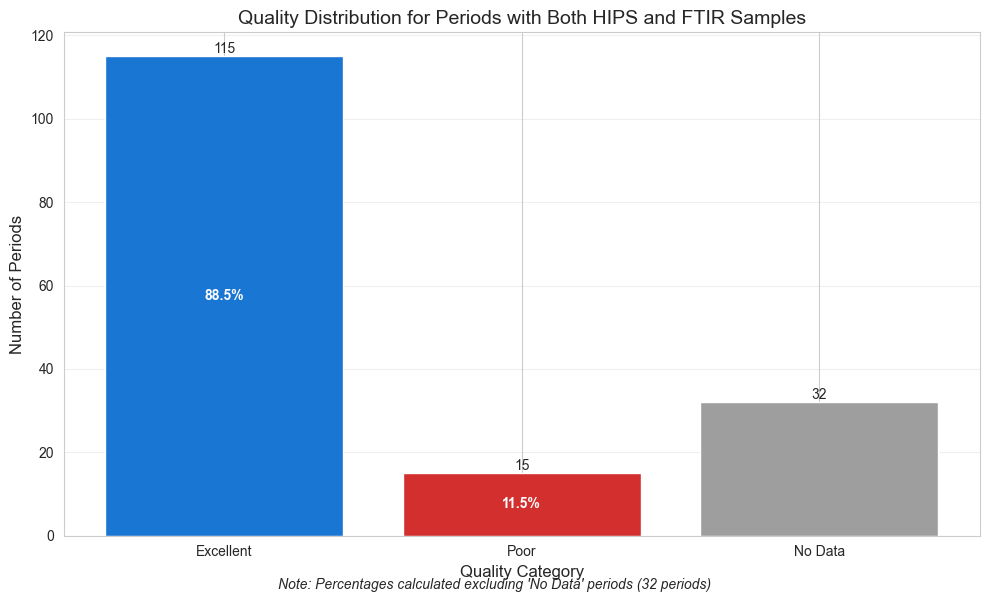

<Figure size 1500x800 with 0 Axes>

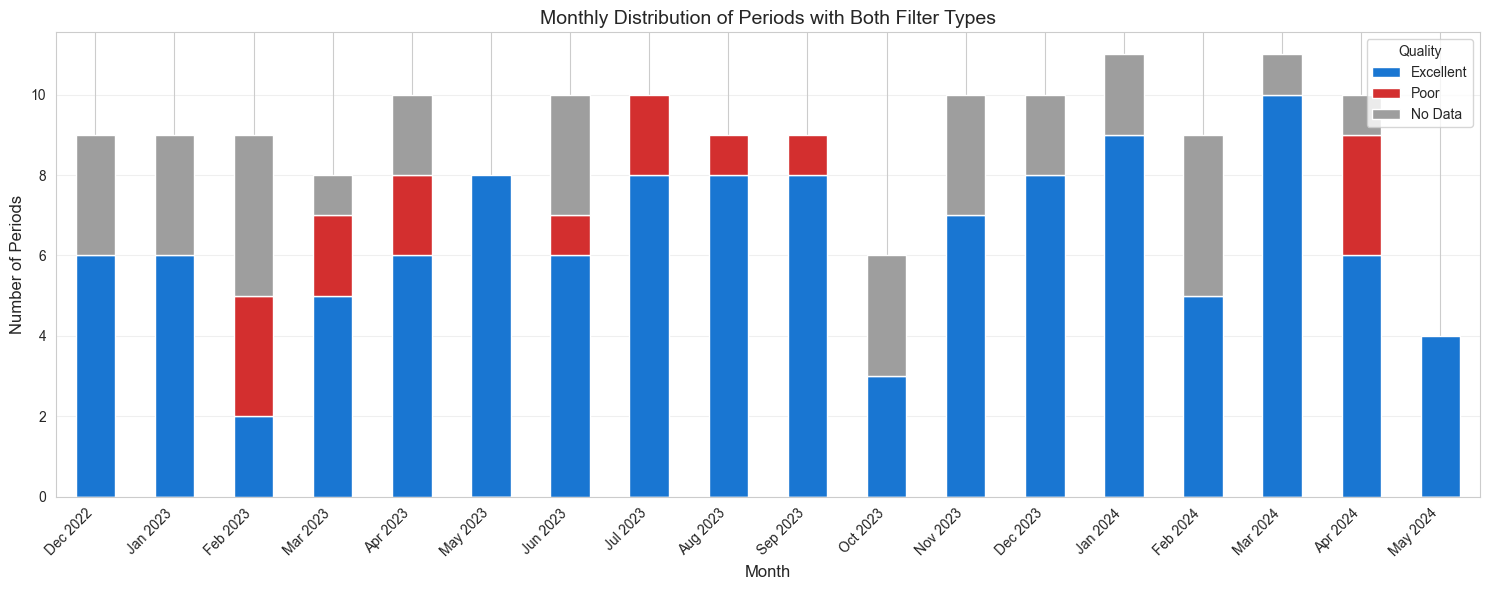


💾 Creating comprehensive filter sample export with ALL aethalometer quality classifications...
• Total filter sample periods found: 162
• All samples in the database have both HIPS and FTIR measurements
• Using quality_by_period Series with 684 entries
• Found 130 filter dates with direct quality matches
• Extracting quality data from both_filters_df
• Quality period counts:
  - Excellent: 605 periods
  - Good: 8 periods
  - Moderate: 10 periods
  - Poor: 61 periods

• Aethalometer quality distribution for ALL filter samples:
  - Excellent: 115 periods (71.0%)
  - Missing: 32 periods (19.8%)
  - Poor: 15 periods (9.3%)

• Filter type distribution:
  - HIPS only: 0 periods (0.0%)
  - FTIR only: 0 periods (0.0%)
  - Both filters: 162 periods (100.0%)

• First 10 filter sample periods (comprehensive data):
                             start_time            end_time  in_hips  in_ftir  \
2022-12-07 09:00:00 2022-12-07 09:00:00 2022-12-08 09:00:00     True     True   
2022-12-10 09:00:00 20

In [54]:
# Execution code that uses the updated database approach

# Load filter sample data from database
etad_data, ftir_data = load_filter_sample_data()

# Re-classify aethalometer data based on 9am-to-9am periods
quality_by_period = classify_aethalometer_9to9_periods(df, quality_by_day)

# Analyze overlap with high-quality periods
overlap_results = analyze_filter_sample_quality_overlap(quality_by_period, etad_data, ftir_data)

# Run the modified function that excludes "No Data" from percentage calculations
both_filters_analysis = analyze_both_filters_quality(overlap_results, include_no_data_in_percentages=False)

# Add the both_filters_analysis to the results dictionary for our enhanced function to use
overlap_results['both_filters_df'] = both_filters_analysis

# Run the enhanced export function that includes ALL quality classifications
all_quality_filter_dates = save_comprehensive_filter_dates_all_quality(
    overlap_results,
    output_path='output/all_filter_dates_with_complete_quality_9to9.csv'
)

# Now check the quality distribution for days with both filter types
both_filters = all_quality_filter_dates[all_quality_filter_dates['has_both_filters']]
print("\n📊 Validation - BOTH filter types quality distribution:")
print(both_filters['aethalometer_quality'].value_counts())